# Tutorial on ensemble history matching methods and ensamble optimisation

This (Jupyter/Python) notebook presents
a tutorial on history matching (using ensemble methods), data optimazation (using ensemble methods) and finally using EnKF and EnOpt in Closed-Loop Reservoir Management.

In this (Jupyter notebook) EnKF and EnOpt are based on:

A. J. Hong , R. B. Bratvold, G. Nævdal, Robust production optimization with capacitance-resistance
model as precursor:  https://doi.org/10.1007/S10596-017-9666-8


This tutorial is based on "Tutorial on ensemble history matching and optimisation" by Patrick N. Raanes:
https://github.com/patricknraanes




Copyright Siavash Heydari, UiS, 2021.

Details may be lacking. This is a work in progress.
Don't hesitate to send me an email with any questions you have.

<mark><font size="-1">
<em>Note:</em> Following added by Siavash H.
</font></mark>

#### Executing the scrpit with Jupyter notebook


Install Anaconda.

Open the Anaconda terminal(Anaconda Prompt) and run the following commands:

>conda create --yes --name my-env python=3.7

>conda activate my-env

Keep using the same terminal for the commands below.

Use files in this folder or download and unzip (or git clone) HistoryMatching repository

In Anaconda terminal use:
> cd "path/to" (folder
command to change the directory to location you saved the "HistoryMatching repository").

>pip install -r "path/to/"requirements.txt

Launch the "notebook server" by executing: 
>jupyter notebook

If the set up goes correct, for next times there is no need to do mentioned steps, otherwise in Anaconda terminal:

>conda activate my-env 

and following steps.
finally step open file “EnKF_MAIN.ipynb”.

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import mpl_setup
mpl_setup.init()

## Setup
Run the following cells to import some tools...

In [2]:
from copy import deepcopy

In [3]:
import scipy.linalg as sla
from matplotlib import ticker
from mpl_tools.fig_layout import freshfig
from numpy.random import randn
from numpy import sqrt
from struct_tools import DotDict
from tqdm.auto import tqdm as progbar
from pynverse import inversefunc

and the model, ...

In [4]:
import geostat
import simulator
import simulator.plotting as plots
from simulator import simulate
from tools import RMS, RMS_all, center, mean0, pad0, svd0, inflate_ens

 extra plots

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
import matplotlib.image as mpimg

In [6]:
plots.COORD_TYPE = "rel"  # can be abs , rel , ind
cmap = plt.get_cmap("jet")

... and initialize some data containers.

In [7]:
# Permeability
perm = DotDict()  #CLRM=DotDict(),

#Porosity
por=DotDict()

# Production (water saturation)
prod = DotDict(
    past=DotDict(),
    future=DotDict(),
    updated=DotDict(),
    tot=DotDict(),
    Truth=DotDict(),
    CLRM=DotDict(),
)

# Water saturation
wsat = DotDict(
    initial=DotDict(),
    past=DotDict(),
    future=DotDict(),
    updated=DotDict(),
    EnKF=DotDict(),
    tot=DotDict(),
    CLRM=DotDict(),
    Truth=DotDict(),
)


Enable exact reproducibility by setting random generator seed.

In [8]:
seed = np.random.seed(4)  # very easy
# seed = np.random.seed(5)  # hard
# seed = np.random.seed(6)  # very easy
# seed = np.random.seed(7)  # easy

## Model and case specification
The reservoir model, which takes up about 100 lines of python code, is a 2D, two-phase, immiscible, incompressible simulator using TPFA. It was translated from the matlab code here http://folk.ntnu.no/andreas/papers/ResSimMatlab.pdf

We will estimate the log permeability field. The data will consist in the water cut of the production, which equals the water saturations at the well locations.

## Import 
             dimension of 2D reservoir
             number of realizations
             time intervals

In [9]:
Nx=20             #dimension in X axis
Ny=20             #dimension in Y axis
N= 100             #number of realization
time_int=10       #time iterval e.g. 40 years

In [10]:
model = simulator.ResSim(Nx=Nx, Ny=Ny, Lx=2, Ly=2)  #size of reservoir is calculated as Nx,Ny 

#### Permeability sampling
We work with log permeabilities, which can (in principle) be Gaussian.


The Gaussian variogram model
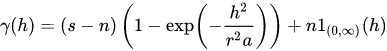

  nugget n: The height of the jump of the semivariogram at the discontinuity at the origin.

  sill s: Limit of the variogram tending to infinity lag distances.
  
  range r: The distance in which the difference of the variogram from the sill becomes negligible. In models with a fixed sill,          it is the distance at which this is first reached; for models with an asymptotic sill, it is conventionally taken to be          the distance when the semivariance first reaches 95% of the sill.
  
  distance h.

#### Variogram parameters:

     ** In this variogram  Sill is 1 and Nugget is 0.
  
  

  
  
  

In [11]:
def sample_log_perm(N=1):
    lperms = geostat.gaussian_fields(model.mesh(), N, r=0.431)
    return lperms

The transformation of the parameters to model input is effectively part of the forward model.

In [12]:
def f_perm(x):
    return .1 + np.exp(5*x)
    #return 1000*np.exp(3*x)

In [13]:
def set_perm(model, log_perm_array):
    p = f_perm(log_perm_array)
    p = p.reshape(model.shape)
    model.Gridded.K = np.stack([p, p])

Here we sample the permeabilitiy of the (synthetic) truth.

In [14]:
perm.Truth = sample_log_perm()
set_perm(model, perm.Truth)

#### Porosity sampling


<mark><font size="-1">
<em>Note:</em> Following added by Siavash H.
</font></mark>

In [15]:
def poro_covn(perm_val):
    CKR = (lambda x: 1.7147*(10**-7) * x**3/(1-x)**2)
    K_val =f_perm(perm_val) * 9.869233 * 1e-13
    poro=inversefunc(CKR, y_values=K_val ,domain=-10)
    poro[poro<0]=0.1                     #min porosity
    poro[poro>0.476]=0.476               # max porosity
    return poro

2 below cells import porosity values in reservior model & then simulator use them.
Running time will increase significantly 

In [16]:
# def set_poro(model, poro_array):
#     po = poro_array.reshape(model.shape)
#     model.Gridded.por = po

In [17]:
# por.Truth=poro_covn(perm.Truth)
# set_poro(model, por.Truth)

#### Well specification
We here specify the wells as point sources and sinks, giving their placement and flux.

The boundary conditions are of the Dirichlet type, specifying zero flux. The source terms must therefore equal the sink terms. This is ensured by the `init_Q` function used below.

Well location is defined in relative-form to reservoir dimentions. It means location (x, y) should be defined as 0< x,y<1

rate should be defined as 0 < rate.

Rate of well will be calculated in fraction of sum of all with same type of well.

In [18]:
### Manual well specification

# model.init_Q(
#     #     x    y     rate   
#     inj =[
#         [0.50, 0.50, 2.00],
#     ],
#     prod=[
#         [0.1, 0.10, 1.00],
#                  # [0.10, 0.50, 1.00],
#         [0.10, 0.90, 1.00],
#                 # [0.50, 0.10, 1.00],
#                 # [0.50, 0.50, 1.00],
#                  # [0.50, 0.90, 1.00],
#         [0.90, 0.10, 1.00],
#                 # [0.90, 0.50, 1.00],
#         [0.90, 0.90, 1.00],
#     ]
# );

## Wells on a grid
well_grid = np.linspace(0.1, .9, 2)
well_grid = np.meshgrid(well_grid, well_grid)
well_grid1 = np.stack(well_grid + [np.ones_like(well_grid[0])])
well_grid = well_grid1.T.reshape((-1, 3))
model.init_Q(
    inj =[[0.50, 0.50, 1]],
    prod=well_grid,
);

# Random well configuration
# model.init_Q(
#     inj =np.random.rand(1, 3),
#     prod=np.random.rand(8, 3)
# );

#### Plot true field
                    permeability

<IPython.core.display.Javascript object>


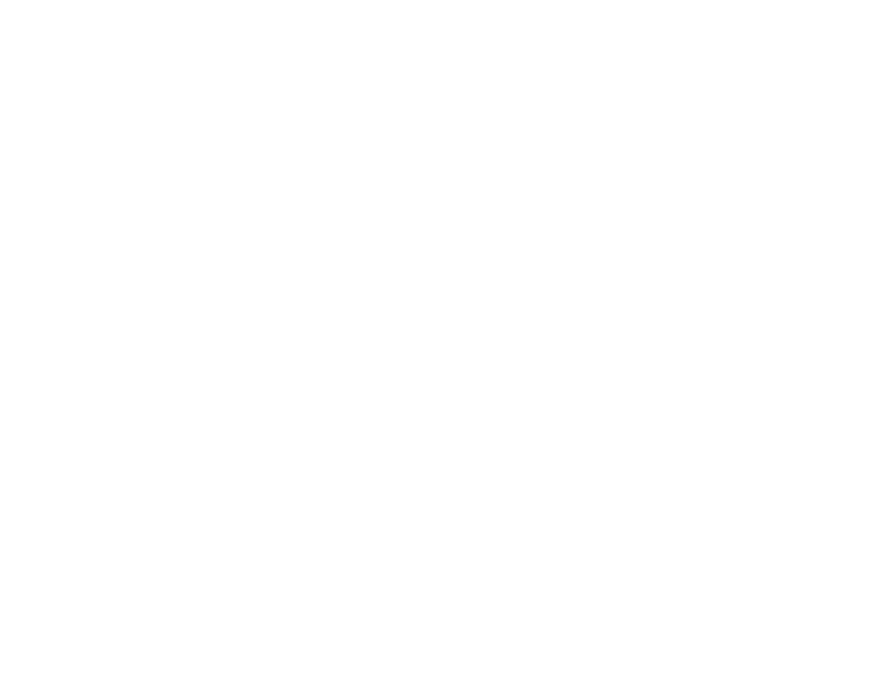

In [19]:
fig, ax = freshfig(110)
# cs = plots.field(model, ax, perm.Truth)
cs = plots.field(model, ax, f_perm(perm.Truth), locator=ticker.LogLocator())
plots.well_scatter(model, ax, model.producers, inj=False)
plots.well_scatter(model, ax, model.injectors, inj=True)
fig.colorbar(cs)
fig.suptitle("True field");
plt.pause(.1)

#### Plot true field
                    porosity
<mark><font size="-1">
<em>Note:</em> Following added by Siavash H.
</font></mark>                    

In [20]:
# fig, ax = freshfig(111)
# cs = plots.field(model, ax,por.Truth)
# #cs = plots.field(model, ax, por.Truth,locator=ticker.LogLocator())
# plots.well_scatter(model, ax, model.producers, inj=False)
# plots.well_scatter(model, ax, model.injectors, inj=True)
# fig.colorbar(cs)
# fig.suptitle("Porosity true field");
# plt.pause(.1)

#### Define obs operator
There is no well model. The data consists purely of the water cut at the location of the wells.

In [21]:
obs_inds = [model.xy2ind(x, y) for (x, y, _) in model.producers]    #Define observation in well cell

def obs(water_sat):
    return [water_sat[i] for i in obs_inds]
obs.length = len(obs_inds)

print("location of production well",obs_inds)

location of production well [42, 57, 342, 357]


### Reservoir Geologiacl /Production model

In [22]:
model.step

<bound method ResSim.step of ResSim({
               'Lx': 2,
               'Ly': 2,
               'Nx': 20,
               'Ny': 20,
            'shape': (20, 20),
             'grid': (20, 20, 2, 2),
                'M': 400,
               'hx': 0.1,
               'hy': 0.1,
               'h2': 0.010000000000000002,
          'Gridded': {
                        'K': array([[[2.53958166e-01, 2.70940495e-01, 2.10814511e-01, 3.58936409e-01,
                                      5.56422007e-01, 4.47601406e-01, 1.15225152e+00, 5.21856980e+00,
                                      2.46929652e+00, 4.19264108e-01, 3.96635472e-01, 6.64025289e-01,
                                      2.16824866e-01, 1.06100536e-01, 1.07940006e-01, 1.29683090e+00,
                                      4.30800963e+02, 9.37220402e+03, 3.34390927e+03, 1.76981874e+02],
                                     [1.45062258e-01, 1.50891658e-01, 1.30277744e-01, 3.48564501e-01,
                                      9

#### Simulation to generate the synthetic truth evolution and data
<mark><font size="-1">
<em>Note:</em> Following edited by Siavash H.
</font></mark>

In [23]:
Swi=0.0                                             #initial water saturation
wsat.initial.Truth = np.zeros(model.M)+Swi


nTime=time_int
T = 1                                            
dt = T/nTime
# nTime = round(T/dt)
wsat.past.Truth, prod.past.Truth = simulate(
    model.step, nTime, wsat.initial.Truth, dt, obs)   #obs is function of water sat in location of wells

Simulation:   0%|          | 0/10 [00:00<?, ?it/s]

##### Animation
Run the code cell below to get an animation of the oil saturation evoluation.
Injection (resp. production) wells are marked with triangles pointing down (resp. up).

<mark><font size="-1">
<em>Note:</em> takes a while to load.
</font></mark>

<IPython.core.display.Javascript object>


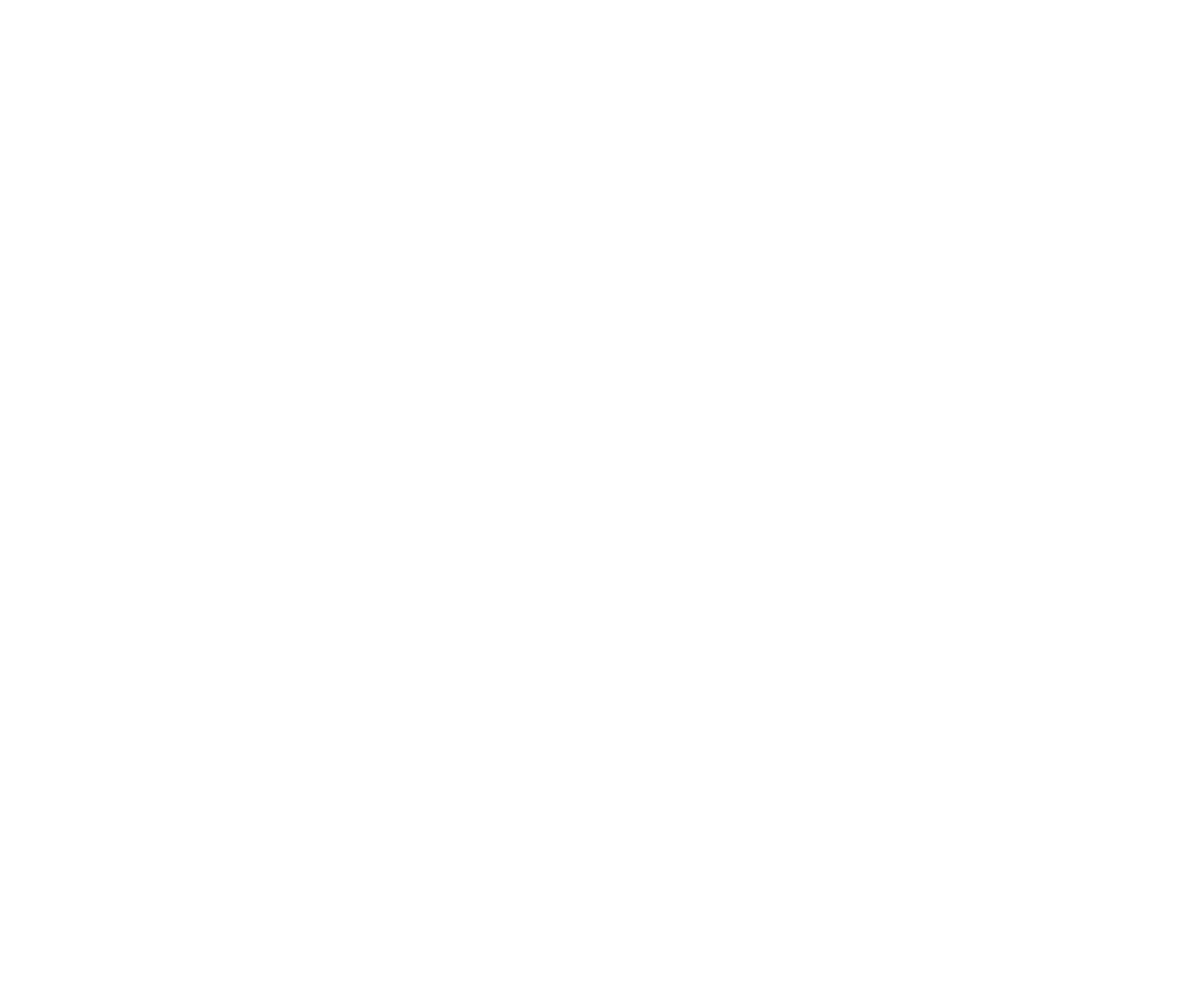

In [24]:
from matplotlib import rc
rc('animation', html="jshtml")
ani = plots.dashboard(model, wsat.past.Truth, prod.past.Truth, animate=True, title="Truth");
ani

#### Noisy obs
In reality, observations are never perfect. To account for this, we corrupt the observations by adding a bit of noise.

In [25]:
nobs=nTime                                              # num. of obs (per time)                                     
prod.past.Noisy = prod.past.Truth.copy()
nProd = len(model.producers)  
R = 1e-3 * np.eye(nProd)
for iT in range(nobs):
    prod.past.Noisy[iT] += sqrt(R) @ randn(nProd)

Plot of observations (and their noise):

<IPython.core.display.Javascript object>


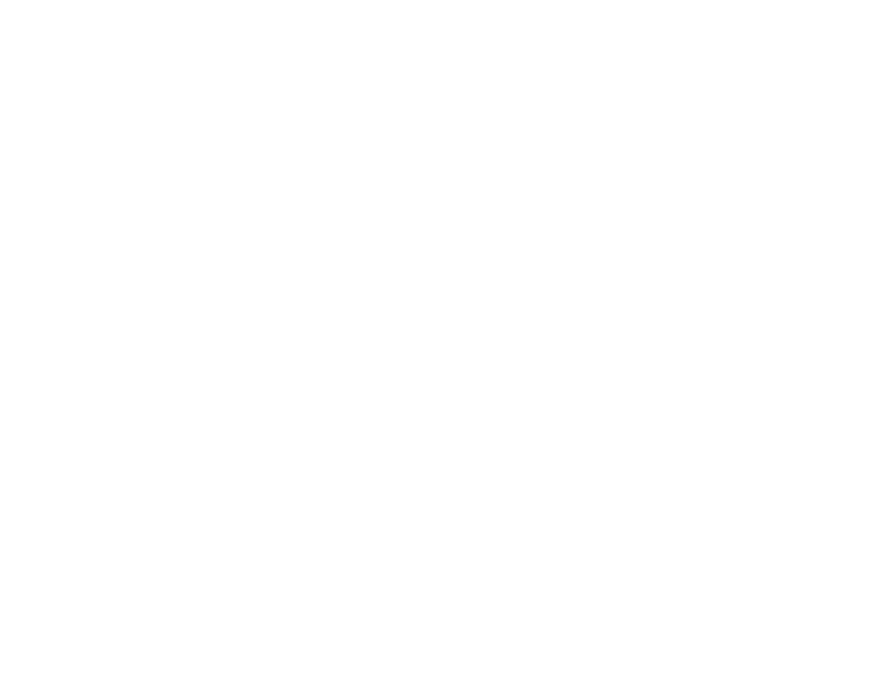

In [26]:
fig, ax = freshfig(122)
hh_y = plots.production1(ax, prod.past.Truth, obs=prod.past.Noisy)
plt.pause(.1)

## Prior
The prior ensemble is generated in the same manner as the (synthetic) truth, using the same mean and covariance.  Thus, the members are "statistically indistinguishable" to the truth. This assumption underlies ensemble methods.

In [27]:
perm.Prior = sample_log_perm(N)

In [28]:
# Note that field (before transformation) is Gaussian with (expected) mean 0 and variance 1.
print("Prior mean:", np.mean(perm.Prior))
print("Prior var.:", np.var(perm.Prior))

Prior mean: -0.0009033009600291259
Prior var.: 0.9957854218819746


Let us inspect the parameter values in the form of their histogram.

In [29]:
# fig, ax = freshfig(130, figsize=(12, 3))
# for label, data in perm.items():

#     ax.hist(
#         f_perm(data.ravel()),
#         f_perm(np.linspace(-3, 3, 32)),
#         # "Downscale" ens counts by N. Necessary because `density` kw
#         # doesnt work "correctly" with log-scale.
#         weights = (np.ones(model.M*N)/N if label != "Truth" else None),
#         label=label, alpha=0.3)

#     ax.set(xscale="log", xlabel="Permeability", ylabel="Count")
#     ax.legend();
# plt.pause(.1)

The above histogram should be Gaussian histogram if f_perm is purely exponential:

Below we can see some realizations (members) from the ensemble.

<IPython.core.display.Javascript object>


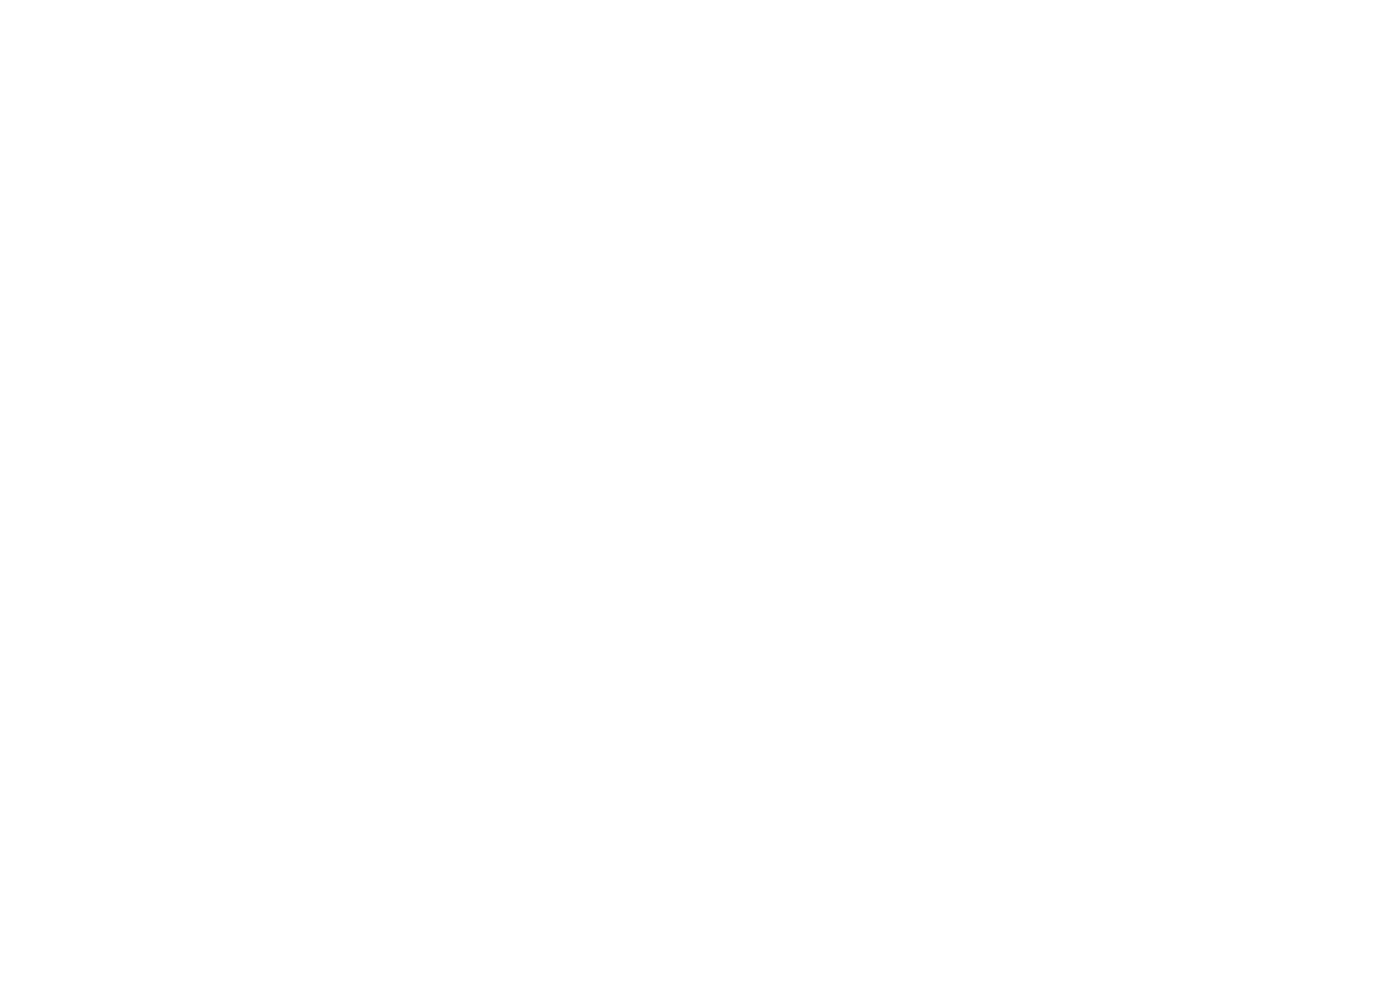

In [30]:
plots.fields(model, 20, plots.field, perm.Prior,
             figsize=(14, 10), cmap=cmap,
             title="Prior -- some realizations of perm");    #max 12 plots of realization

<IPython.core.display.Javascript object>


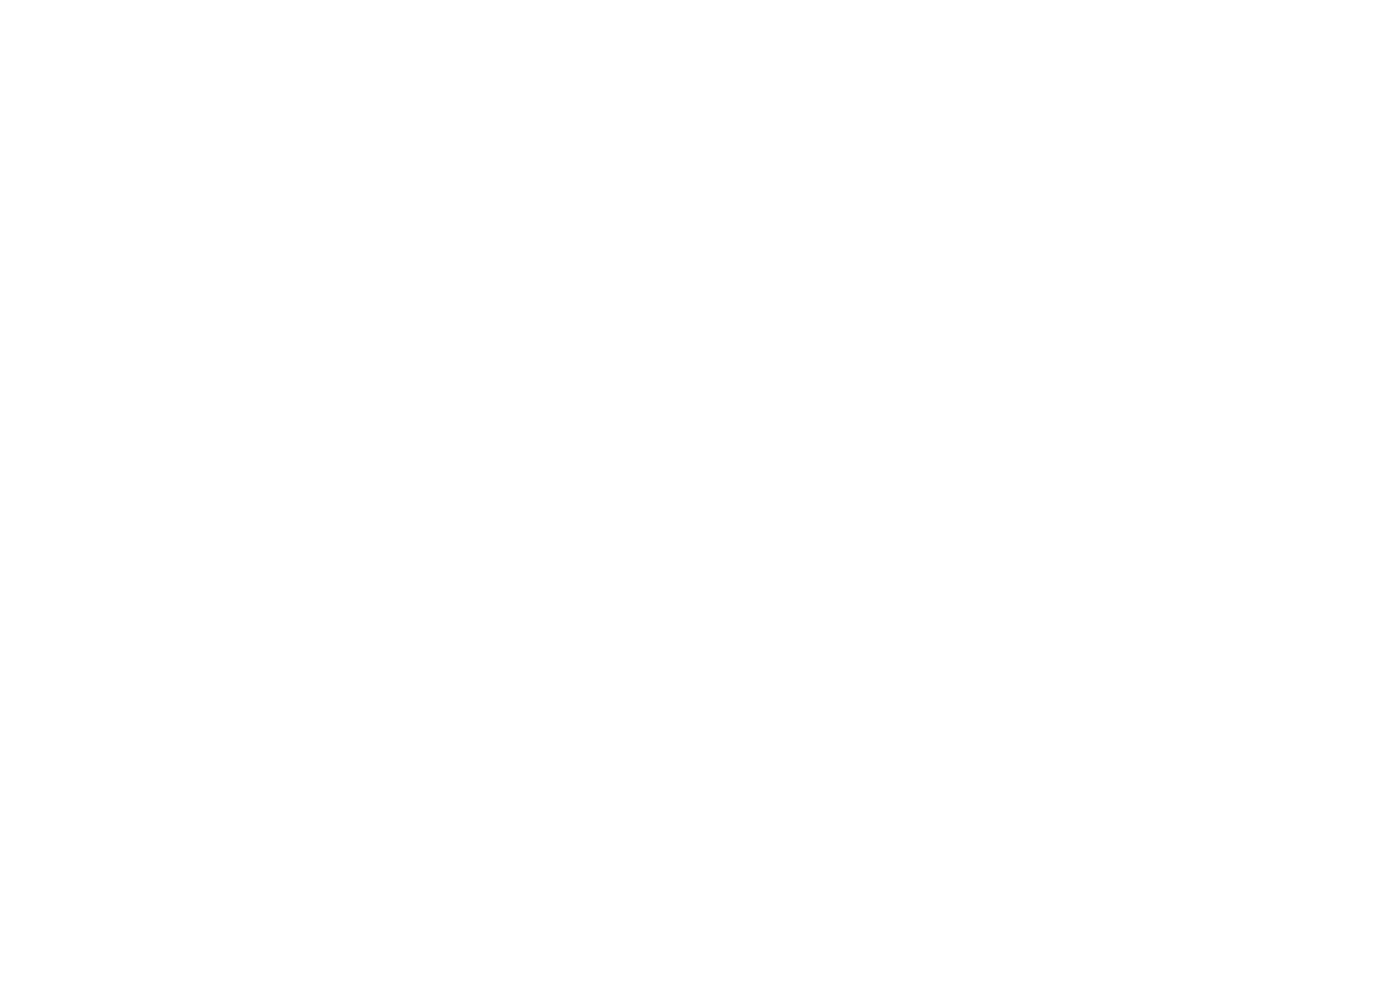

In [31]:
por.Prior=poro_covn(perm.Prior)
plots.fields(model, 162, plots.field, por.Prior,
             figsize=(14, 10), cmap=cmap,
             title="Prior -- some realizations of porosity");

#### Eigenvalue specturm
In practice, of course, we would not be using an explicit `Cov` matrix when generating the prior ensemble, because it would be too large.  However, since this synthetic case in being made that way, let's inspect its spectrum.

<IPython.core.display.Javascript object>


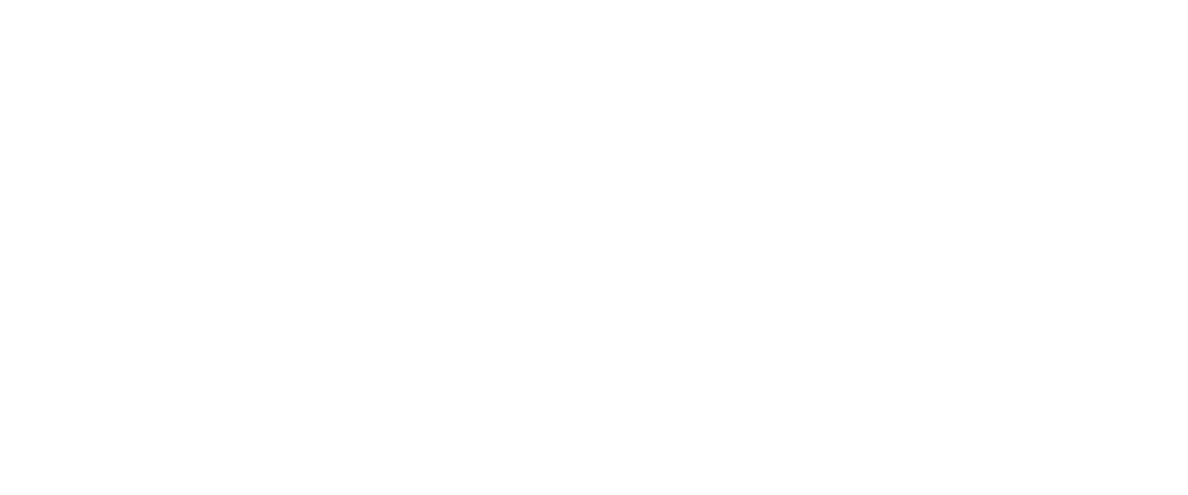

In [32]:
U, svals, VT = sla.svd(perm.Prior)  #Singular value decomposition
ii = 1+np.arange(len(svals))
fig, ax = freshfig(150, figsize=(12, 5))
ax.loglog(ii, svals)
# ax.semilogx(ii, svals)
ax.grid(True, "minor", axis="x")
ax.grid(True, "major", axis="y")
ax.set(xlabel="eigenvalue #", ylabel="var.",
       title="Spectrum of initial, true cov");
plt.pause(.1)

## Assimilation

#### Exc (optional)
Before going into iterative methods, we note that
the ensemble smoother (ES) is favoured over the ensemble Kalman smoother (EnKS) for history matching. This may come as a surprise, because the EnKS processes the observations sequentially, like the ensemble Kalman filter (EnKF), not in the batch manner of the ES. Because sequential processing is more gradual, one would expect it to achieve better accuracy than batch approaches. However, the ES is preferred because the uncertainty in the state fields is often of less importance than the uncertainty in the parameter fields. More imperatively, (re)starting the simulators (e.g. ECLIPSE) from updated state fields (as well as parameter fields) is a troublesome affair; the fields may have become "unphysical" (or "not realisable") because of the ensemble update, which may hinder the simulator from producing meaningful output (it may crash, or have trouble converging). On the other hand, by going back to the parameter fields before geological modelling (using fast model update (FMU)) tends to yield more realistic parameter fields. Finally, since restarts tend to yield convergence issues in the simulator the following inequality is usually large.

$$
\begin{align}
	\max_n \sum_{t}^{} T_t^n < \sum_{t}^{} \max_n T_t^n,
	\label{eqn:max_sum_sum_max}
\end{align}
$$
skjervheim2011ensemble
Here, $T_t^n$

#### Propagation
Ensemble methods obtain observation-parameter sensitivities from the covariances of the ensemble run through the model. Note that this for-loop is "embarrasingly parallelizable", because each iterate is complete indepdendent (requires no communication) from the others.

In [33]:
multiprocess = False  # multiprocessing?

In [34]:
def forecast(nTime, wsats0, perms, Q_prod=None, desc="En. forecast"):
    """Forecast for an ensemble."""
    # Compose ensemble
    if Q_prod is None:
        E = zip(wsats0, perms)            #zip makes tuple
    else:
        E = zip(wsats0, perms, Q_prod)

    def forecast1(x):
        model_n = deepcopy(model)

        if Q_prod is None:
            wsat0, perm = x
            # Set ensemble
            set_perm(model_n, perm)
        else:
            wsat0, perm, q_prod = x
            # Set production rates
            prod = model_n.producers
            prod = well_grid  # model_n.producers uses abs scale
            prod[:, 2] = q_prod
            model_n.init_Q(
                inj = model_n.injectors,
                prod = prod,
            )
            # Set ensemble
            set_perm(model_n, perm)

        # Simulate
        s, p = simulate(model_n.step, nTime, wsat0, dt, obs, pbar=False)
        return s, p

    # Allocate
    production = np.zeros((N, nTime, nProd))
    saturation = np.zeros((N, nTime+1, model.M))

    # Dispatch
    if multiprocess:
        import multiprocessing_on_dill as mpd
        with mpd.Pool() as pool:
            E = list(progbar(pool.imap(forecast1, E), total=N, desc=desc))
        # Write
        for n, member in enumerate(E):
            saturation[n], production[n] = member

    else:
        for n, xn in enumerate(progbar(list(E), "Members")):
            s, p = forecast1(xn)
            # Write
            saturation[n], production[n] = s, p

    return saturation, production

We also need to set the prior for the initial water saturation. As mentioned, this is not because it is uncertain/unknown; indeed, this case study assumes that it is perfectly known (i.e. equal to the true initial water saturation, which is a constant field of 0). However, in order to save one iteration, the posterior will also be output for the present-time water saturation (state) field, which is then used to restart simulations for future prediction (actually, the full time series of the saturation is output, but that is just for academic purposes). Therefore the ensemble forecast function must take water saturation as one of the inputs. Therefore, for the prior, we set this all to the true initial saturation (giving it uncertainty 0).

<mark><font size="-1">
<em>Note:</em> Following cells edited by Siavash H.
</font></mark>

In [35]:
wsat.initial.Prior = np.tile(wsat.initial.Truth, (N, 1)) 

Now we run the forecast.

In [36]:
wsat.past.Prior, prod.past.Prior = forecast(
    nTime, wsat.initial.Prior, perm.Prior)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

### Ensemble Kalman filter
<mark><font size="-1">
<em>Note:</em> Following added by Siavash H.
</font></mark>

In [37]:
# up_time=nTime                                                         #for each measurement  

# mf_k=perm.Prior.T                                                     #dynamic_reservoir_model
# Xf_k=wsat.initial.Prior.T                                             #state_variables
# gf_k=(prod.past.Prior[:,0,:]).T                                       #observation_current
# Yf_k_new=np.concatenate((mf_k,Xf_k,gf_k))



# for time in range (up_time):
    
       
# #     Vk=np.random.normal(0,np.cov(prod.past.Truth[time,:]),N)
#     Vk=np.random.multivariate_normal(np.zeros(nProd), R, N).T
#     Cd_k= 1e-3 * np.eye(nProd)  #1/(N-1)* Vk @ Vk.T
    
#     obs_real= np.asmatrix(prod.past.Noisy[time,:]).T
#     dk =  np.asarray(np.tile(obs_real,(1,N)) + Vk) 
 
#     ###
        
#     Yf_k = Yf_k_new
#     Pf_k = np.cov(Yf_k)                                                #error covariance matrix
#     H = gf_k @  sla.pinv2(Yf_k)
#     ###
#     #print("t",time)
    
#     Kk= (Pf_k @ H.T) @ sla.pinv2(H @ Pf_k @ H.T + Cd_k)                #Kalman gain
    
#     Yu_k_new = Yf_k + Kk @ (dk - H @ Yf_k)
#     #Pu_k_new = np.cov(Yu_k_new)
#     ###
    
#     perm1_updated = Yu_k_new[:model.M,:]
#     wsat1_updated = Yu_k_new[model.M:2*model.M,:]
    
#     wsat_updated, prod_updated = forecast(1, wsat1_updated.T, perm1_updated.T)
#     wsat_updated[wsat_updated<0]=0
#     wsat_updated[wsat_updated>1]=1
# # #     ###
    
#     mf_k=Yu_k_new[:model.M,:]                                            #updated:dynamic_reservoir_model
#     Xf_k=wsat_updated[:,1,:].T                                           #updated:state_variables, forecast function create 2 sets of wsat
#     gf_k=(prod_updated[:,0,:]).T                                         #observation_current
#     Yf_k_new=np.concatenate((mf_k,Xf_k,gf_k))

# # # ####
# perm.EnKF = Yu_k_new[:model.M,:].T
# wsat.updated = wsat_updated[:,1,:].T

In [38]:
up_time=nTime 
def EnKF(mf_k, Xf_k, gf_k, nProd=nProd, Noisy=prod.past.Noisy, size=model.M,up_time=up_time):
    
    
    
                                                              

#     mf_k=perm.Prior.T                                                     
#     Xf_k=wsat.initial.Prior.T                                             #state_variables
#     gf_k=(prod.past.Prior[:,0,:]).T                                       #observation_current
    Yf_k_new=np.concatenate((mf_k,Xf_k,gf_k))



    for time in range (up_time):


    #     Vk=np.random.normal(0,np.cov(prod.past.Truth[time,:]),N)
        Vk=np.random.multivariate_normal(np.zeros(nProd), R, N).T
        Cd_k= 1e-3 * np.eye(nProd)                                        #1/(N-1)* Vk @ Vk.T

        obs_real= np.asmatrix(Noisy[time,:]).T
        dk =  np.asarray(np.tile(obs_real,(1,N)) + Vk) 

        Yf_k = Yf_k_new
        Pf_k = np.cov(Yf_k)                                                #error covariance matrix
        H = gf_k @  sla.pinv2(Yf_k)
        ###
        

        Kk= (Pf_k @ H.T) @ sla.pinv2(H @ Pf_k @ H.T + Cd_k)                #Kalman gain

        Yu_k_new = Yf_k + Kk @ (dk - H @ Yf_k)
        #Pu_k_new = np.cov(Yu_k_new)
        ###

        perm1_updated = Yu_k_new[:size,:]
        wsat1_updated = Yu_k_new[size:2*size,:]

        wsat_updated, prod_updated = forecast(1, wsat1_updated.T, perm1_updated.T)
        wsat_updated[wsat_updated<0]=0
        wsat_updated[wsat_updated>1]=1
    # #     ###

        mf_k=Yu_k_new[:size,:]                                            #updated:dynamic_reservoir_model
        Xf_k=wsat_updated[:,1,:].T                                           #updated:state_variables, forecast function create 2 sets of wsat
        gf_k=(prod_updated[:,0,:]).T                                         #observation_current
        Yf_k_new=np.concatenate((mf_k,Xf_k,gf_k))

    # # ####
    p = Yu_k_new[:size,:].T
    w = wsat_updated[:,-1,:].T
    return p,w

In [39]:
perm.EnKF,  wsat.updated= EnKF(mf_k=perm.Prior.T,                       #dynamic_reservoir_model
                               Xf_k=wsat.initial.Prior.T,               #state_variables,
                               gf_k=(prod.past.Prior[:,0,:]).T          #observation_current
                              )

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

#### Plot EnKF 
Let's plot the updated, initial ensemble.

<IPython.core.display.Javascript object>


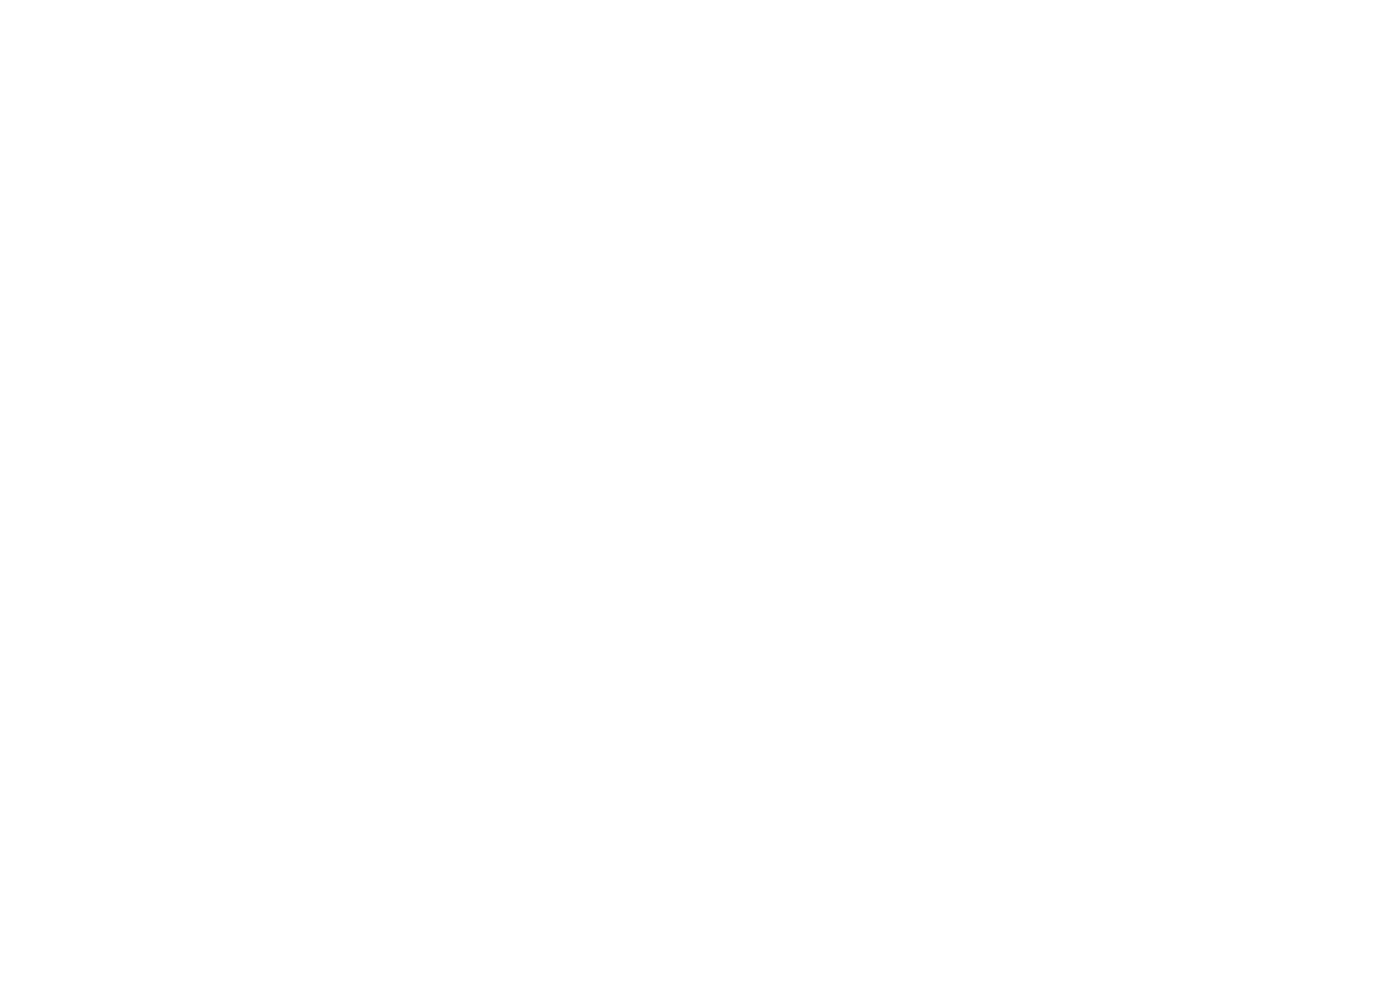

In [40]:
plots.fields(model, 100, plots.field, perm.EnKF,   #perm.EnKF[10:22]
             figsize=(14, 10), cmap=cmap,
             title="Enkf posterior -- some realizations of perm");

<IPython.core.display.Javascript object>


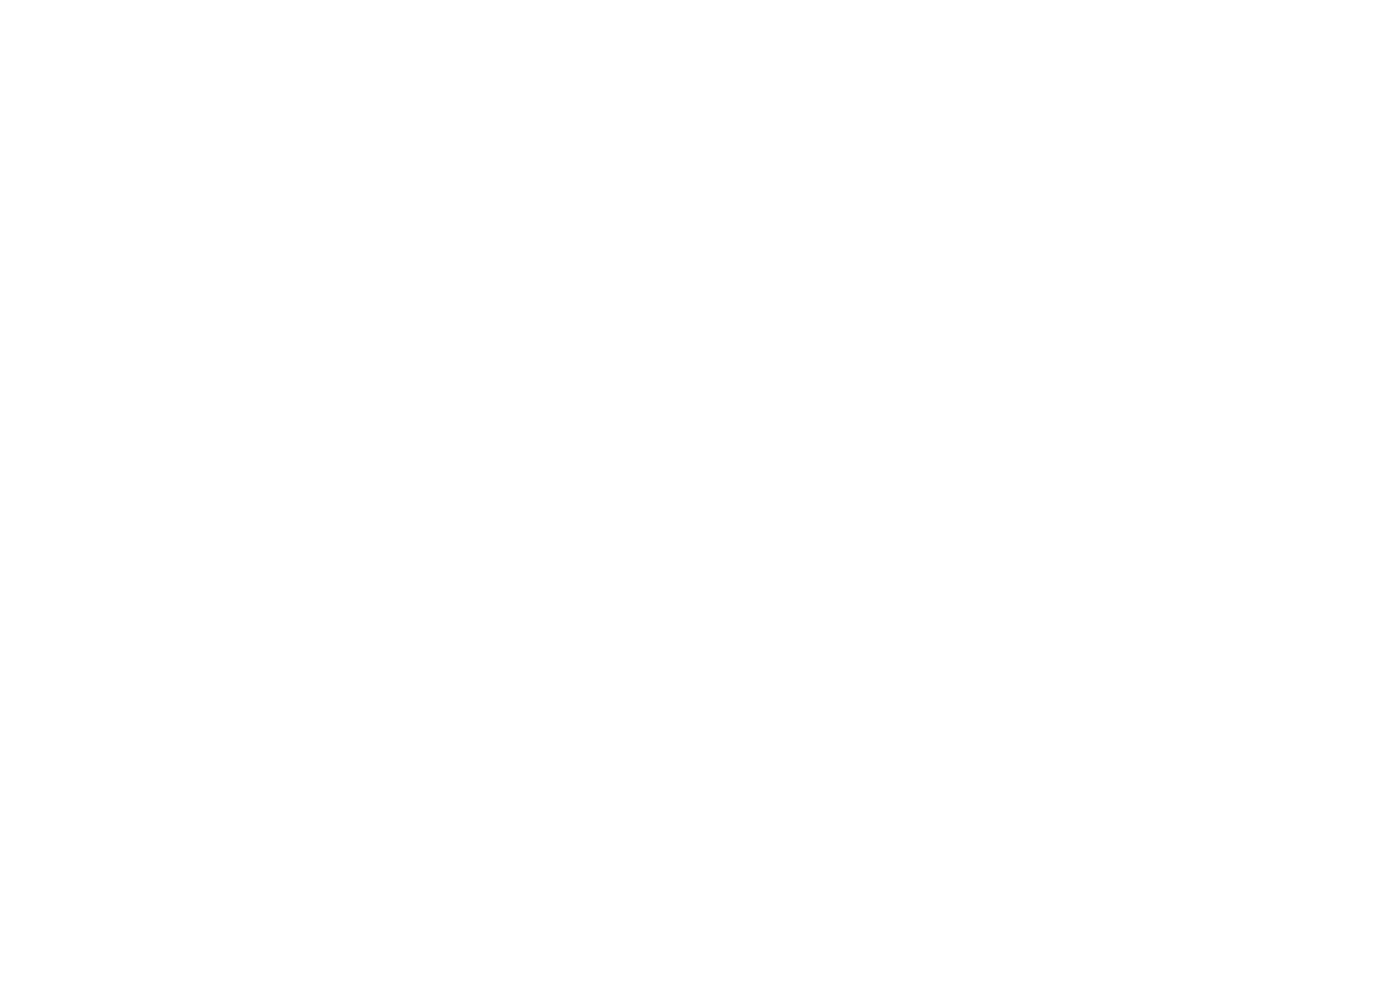

In [41]:
por.EnKF=poro_covn(perm.EnKF)
plots.fields(model, 163, plots.field, por.EnKF,
             figsize=(14, 10), cmap=cmap,
             title="Enkf posterior -- some realizations of porosity");

### Ensemble smoother

In [42]:
class ES_update:
    """Update/conditioning (Bayes' rule) for an ensemble,

    according to the "ensemble smoother" (ES) algorithm,

    given a (vector) observations an an ensemble (matrix).

    NB: obs_err_cov is treated as diagonal. Alternative: use `sla.sqrtm`.

    Why have we chosen to use a class (and not a function)?
    Because this allows storing `KGdY`, which we can then/later re-apply,
    thereby enabling state-augmentation "on-the-fly".

    NB: some of these formulea appear transposed, and reversed,
    compared to (EnKF) literature standards. The reason is that
    we stack the members as rows instead of the conventional columns.
    Rationale: https://nansencenter.github.io/DAPPER/dapper/index.html#conventions
    """

    def __init__(self, obs_ens, observation, obs_err_cov):
        """Prepare the update."""
        Y           = mean0(obs_ens)
        obs_cov     = obs_err_cov*(N-1) + Y.T@Y  #P
        obs_pert    = randn(N, len(observation)) @ sqrt(obs_err_cov)
        innovations = observation - (obs_ens + obs_pert)

        # (pre-) Kalman gain * Innovations
        self.KGdY = innovations @ sla.pinv2(obs_cov) @ Y.T

    def __call__(self, E):
        """Do the update."""
        return E + self.KGdY @ mean0(E)

In [43]:
# #### Update
ES = ES_update(
    obs_ens     = prod.past.Prior.reshape((N, -1)),
    observation = prod.past.Noisy.reshape(-1),
    obs_err_cov = sla.block_diag(*[R]*nTime),          
)

In [44]:
# Apply update
perm.ES = ES(perm.Prior)

#### Plot ES
Let's plot the updated, initial ensemble.

<IPython.core.display.Javascript object>


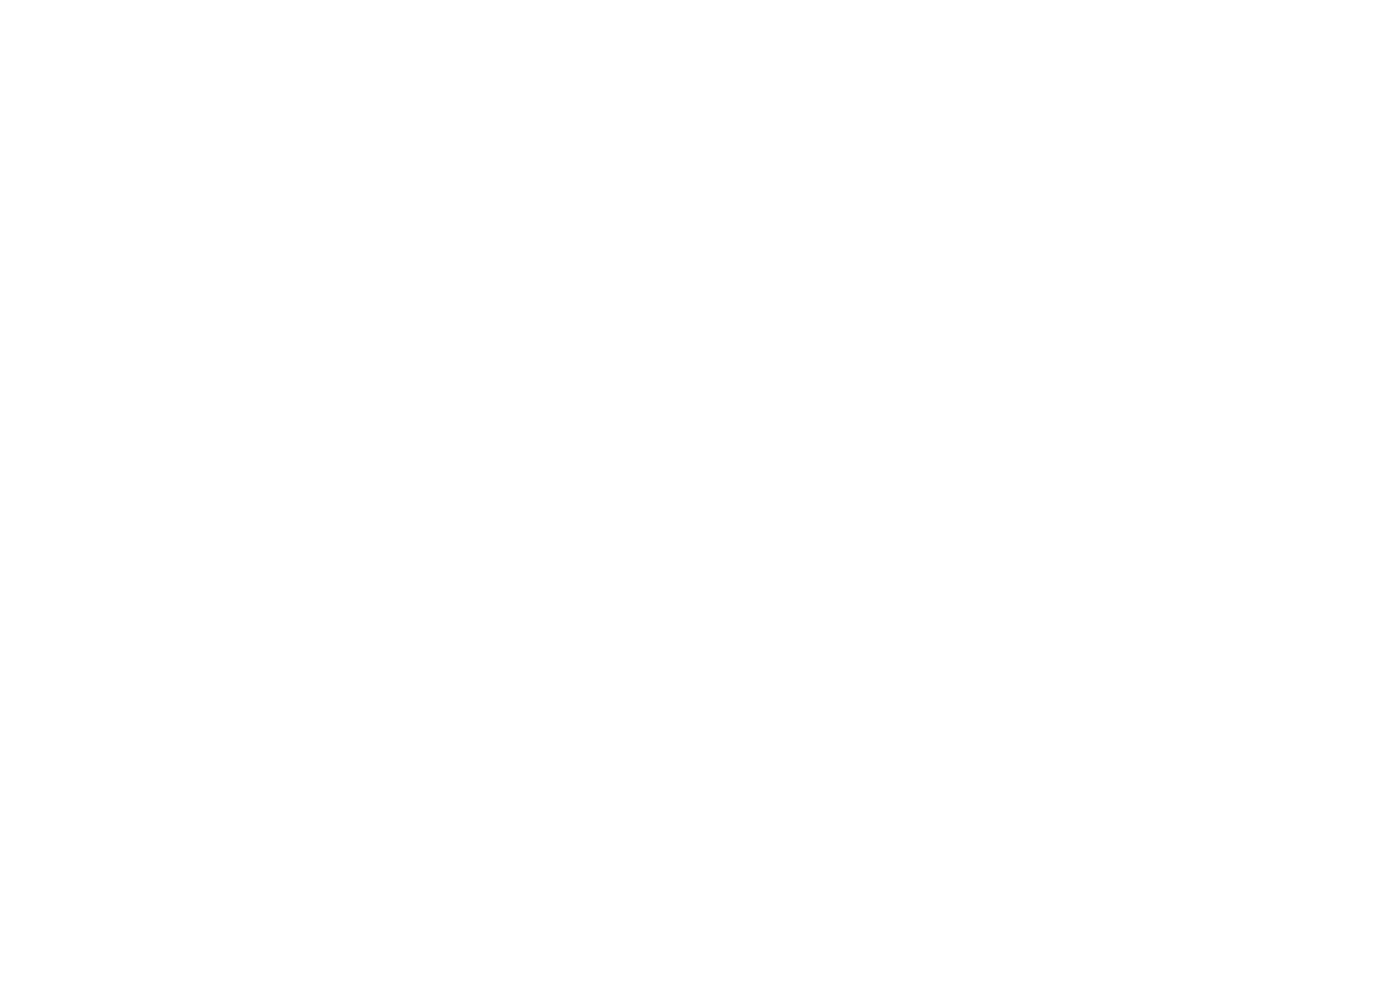

In [45]:
plots.fields(model, 160, plots.field, perm.ES,
             figsize=(14, 10), cmap=cmap,
             title="ES posterior -- some realizations");

In [46]:
por.ES=poro_covn(perm.ES)
plots.fields(model, 162, plots.field, por.ES,
             figsize=(14, 5), cmap=cmap,
             title="ES posterior -- some realizations of porosity");

We will see some more diagnostics later.

### Iterative ensemble smoother
The following is (almost) all that distinguishes all of the fully-Bayesian iterative ensemble smoothers in the literature.

In [47]:
def iES_flavours(w, T, Y, Y0, dy, Cowp, za, N, nIter, itr, MDA, flavour):
    N1 = N - 1
    Cow1 = Cowp(1.0)

    if MDA:  # View update as annealing (progressive assimilation).
        Cow1 = Cow1 @ T  # apply previous update
        dw = dy @ Y.T @ Cow1
        if 'PertObs' in flavour:   # == "ES-MDA". By Emerick/Reynolds
            D   = mean0(randn(*Y.shape)) * sqrt(nIter)
            T  -= (Y + D) @ Y.T @ Cow1
        elif 'Sqrt' in flavour:    # == "ETKF-ish". By Raanes
            T   = Cowp(0.5) * sqrt(za) @ T
        elif 'Order1' in flavour:  # == "DEnKF-ish". By Emerick
            T  -= 0.5 * Y @ Y.T @ Cow1
        Tinv = np.eye(N)  # [as initialized] coz MDA does not de-condition.

    else:  # View update as Gauss-Newton optimzt. of log-posterior.
        grad  = Y0@dy - w*za                  # Cost function gradient
        dw    = grad@Cow1                     # Gauss-Newton step
        # ETKF-ish". By Bocquet/Sakov.
        if 'Sqrt' in flavour:
            # Sqrt-transforms
            T     = Cowp(0.5) * sqrt(N1)
            Tinv  = Cowp(-.5) / sqrt(N1)
            # Tinv saves time [vs tinv(T)] when Nx<N
        # "EnRML". By Oliver/Chen/Raanes/Evensen/Stordal.
        elif 'PertObs' in flavour:
            if itr == 0:
                D = mean0(randn(*Y.shape))
                iES_flavours.D = D
            else:
                D = iES_flavours.D
            gradT = -(Y+D)@Y0.T + N1*(np.eye(N) - T)
            T     = T + gradT@Cow1
            # Tinv= tinv(T, threshold=N1)  # unstable
            Tinv  = sla.inv(T+1)           # the +1 is for stability.
        # "DEnKF-ish". By Raanes.
        elif 'Order1' in flavour:
            # Included for completeness; does not make much sense.
            gradT = -0.5*Y@Y0.T + N1*(np.eye(N) - T)
            T     = T + gradT@Cow1
            Tinv  = sla.pinv2(T)

    return dw, T, Tinv

This outer function loops through the iterations, forecasting, de/re-composing the ensemble, performing the linear regression, validating step, and making statistics.

In [48]:
def iES(ensemble, observation, obs_err_cov,
        flavour="Sqrt", MDA=False, bundle=False,
        stepsize=1, nIter=10, wtol=1e-4):

    E = ensemble
    N = len(E)
    N1 = N - 1
    Rm12T = np.diag(sqrt(1/np.diag(obs_err_cov)))  # TODO?

    stats = DotDict()
    stats.J_lklhd  = np.full(nIter, np.nan)
    stats.J_prior  = np.full(nIter, np.nan)
    stats.J_postr  = np.full(nIter, np.nan)
    stats.rmse     = np.full(nIter, np.nan)
    stats.stepsize = np.full(nIter, np.nan)
    stats.dw       = np.full(nIter, np.nan)

    if bundle:
        if isinstance(bundle, bool):
            EPS = 1e-4  # Sakov/Boc use T=EPS*eye(N), with EPS=1e-4, but I ...
        else:
            EPS = bundle
    else:
        EPS = 1.0  # ... prefer using  T=EPS*T, yielding a conditional cloud shape

    # Init ensemble decomposition.
    X0, x0 = center(E)    # Decompose ensemble.
    w      = np.zeros(N)  # Control vector for the mean state.
    T      = np.eye(N)    # Anomalies transform matrix.
    Tinv   = np.eye(N)
    # Explicit Tinv [instead of tinv(T)] allows for merging MDA code
    # with iEnKS/EnRML code, and flop savings in 'Sqrt' case.

    for itr in range(nIter):
        # Reconstruct smoothed ensemble.
        E = x0 + (w + EPS*T)@X0
        stats.rmse[itr] = RMS(perm.Truth, E).rmse

        # Forecast.
        E_state, E_obs = forecast(nTime, wsat.initial.Prior, E, desc=f"Iteration {itr}")
        E_obs = E_obs.reshape((N, -1))

        # Undo the bundle scaling of ensemble.
        if EPS != 1.0:
            E     = inflate_ens(E, 1/EPS)
            E_obs = inflate_ens(E_obs, 1/EPS)

        # Prepare analysis.Ç
        y      = observation        # Get current obs.
        Y, xo  = center(E_obs)      # Get obs {anomalies, mean}.
        dy     = (y - xo) @ Rm12T   # Transform obs space.
        Y      = Y        @ Rm12T   # Transform obs space.
        Y0     = Tinv @ Y           # "De-condition" the obs anomalies.

        # Set "cov normlzt fctr" za ("effective ensemble size")
        # => pre_infl^2 = (N-1)/za.
        za = N1
        if MDA:
            # inflation (factor: nIter) of the ObsErrCov.
            za *= nIter

        # Compute Cowp: the (approx) posterior cov. of w
        # (estiamted at this iteration), raised to some power.
        V, s, UT = svd0(Y0)
        def Cowp(expo): return (V * (pad0(s**2, N) + za)**-expo) @ V.T

        # TODO: NB: these stats are only valid for Sqrt
        stat2 = DotDict(
            J_prior = w@w * N1,
            J_lklhd = dy@dy,
        )
        # J_posterior is sum of the other two
        stat2.J_postr = stat2.J_prior + stat2.J_lklhd
        # Take root, insert for [itr]:
        for name in stat2:
            stats[name][itr] = sqrt(stat2[name])

        # Accept previous increment? ...
        if (not MDA) and itr > 0 and stats.J_postr[itr] > np.nanmin(stats.J_postr):
            # ... No. Restore previous ensemble & lower the stepsize (dont compute new increment).
            stepsize   /= 10
            w, T, Tinv  = old  # noqa
        else:
            # ... Yes. Store this ensemble, boost the stepsize, and compute new increment.
            old         = w, T, Tinv
            stepsize   *= 2
            stepsize    = min(1, stepsize)
            dw, T, Tinv = iES_flavours(w, T, Y, Y0, dy, Cowp, za, N, nIter, itr, MDA, flavour)

        stats.      dw[itr] = dw@dw / N
        stats.stepsize[itr] = stepsize

        # Step
        w = w + stepsize*dw

        if stepsize * np.sqrt(dw@dw/N) < wtol:
            break

    stats.nIter = itr + 1

    if not MDA:
        # The last step (dw, T) must be discarded,
        # because it cannot be validated without re-running the model.
        w, T, Tinv  = old

    # Reconstruct the ensemble.
    E = x0 + (w+T)@X0

    return E, stats

#### Apply the iES

In [49]:
perm.iES, stats_iES = iES(
    ensemble = perm.Prior,
    observation = prod.past.Noisy.reshape(-1),
    obs_err_cov = sla.block_diag(*[R]*nTime),
    flavour="Sqrt", MDA=False, bundle=False, stepsize=1,
)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

#### Plot iES
Let's plot the updated, initial ensemble.

<IPython.core.display.Javascript object>


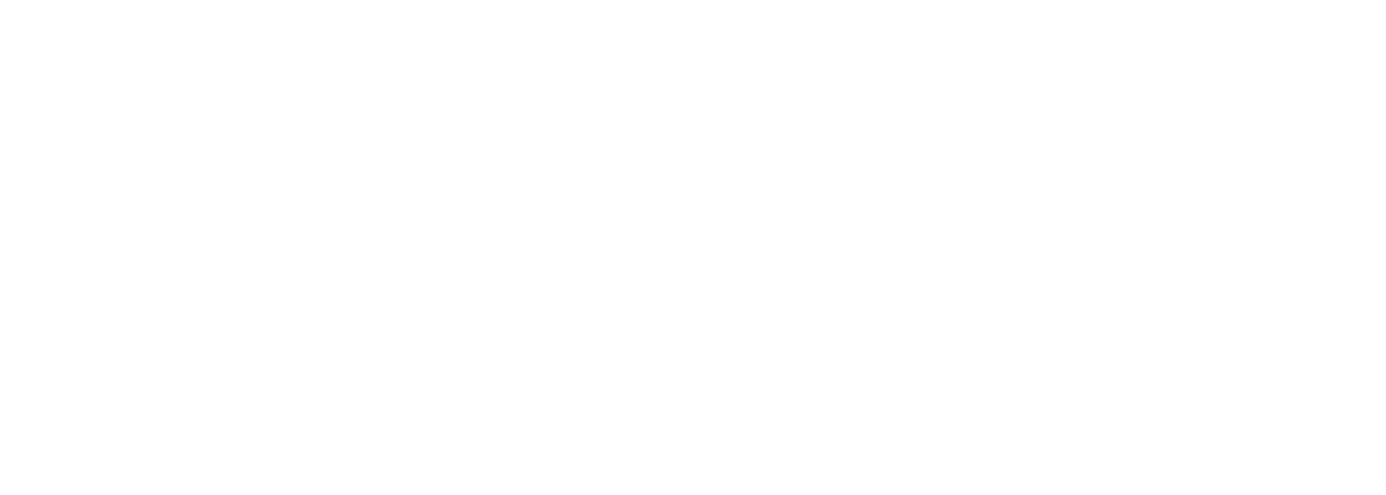

In [50]:
plots.fields(model, 165, plots.field, perm.iES,
             figsize=(14, 5), cmap=cmap,
             title="iES posterior -- some realizations");

In [51]:
por.iES=poro_covn(perm.iES)
plots.fields(model, 162, plots.field, por.iES,
             figsize=(14, 5), cmap=cmap,
             title="iES posterior -- some realizations of porosity");

The following plots the cost function(s) together with the error compared to the true (pre-)perm field as a function of the iteration number. Note that the relationship between the (total, i.e. posterior) cost function  and the RMSE is not necessarily monotonic. Re-running the experiments with a different seed is instructive. It may be observed that the iterations are not always very successful.

<IPython.core.display.Javascript object>


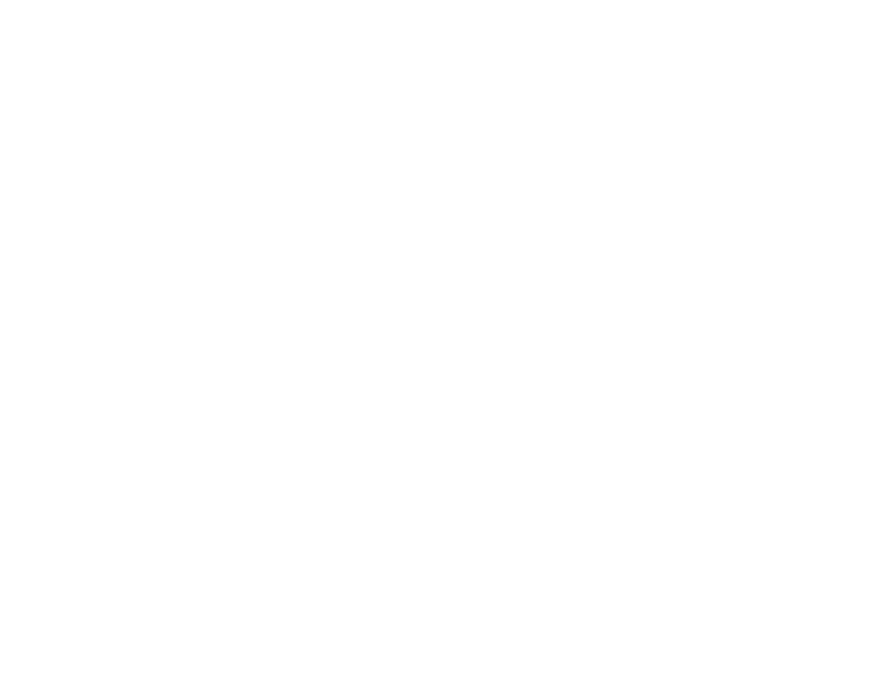

In [52]:
fig, ax = freshfig(167)
ls = dict(J_prior=":", J_lklhd="--", J_postr="-")
for name, J in stats_iES.items():
    try:
        ax.plot(J, color="b", label=name.split("J_")[1], ls=ls[name])
    except IndexError:
        pass
ax.set_xlabel("iteration")
ax.set_ylabel("RMS mismatch", color="b")
ax.tick_params(axis='y', labelcolor="b")
ax.legend()
ax2 = ax.twinx()  # axis for rmse
ax2.set_ylabel('RMS error', color="r")
ax2.plot(stats_iES.rmse, color="r")
ax2.tick_params(axis='y', labelcolor="r")
plt.pause(.1)

### Diagnostics
In terms of root-mean-square error (RMSE), the ES is expected to improve on the prior. The "expectation" wording indicates that this is true on average, but not always. To be specific, it means that it is guaranteed to hold true if the RMSE is calculated for infinitely many experiments (each time simulating a new synthetic truth and observations from the prior). The reason for this is that the ES uses the Kalman update, which is the BLUE (best linear unbiased estimate), and "best" means that the variance must get reduced. However, note that this requires the ensemble to be infinitely big, which it most certainly is not in our case. Therefore, we do not need to be very unlucky to observe that the RMSE has actually increased. Despite this, as we will see later, the data match might yield a different conclusions concerning the utility of the update.

In [53]:
print("Stats vs. true field")
RMS_all(perm, vs="Truth")

Stats vs. true field
Prior   : 0.9619 (rmse),  0.9941 (std)
EnKF    : 1.0127 (rmse),  0.9167 (std)
ES      : 0.9284 (rmse),  0.9104 (std)
iES     : 0.9254 (rmse),  0.8806 (std)


### Plot of means
Let's plot mean fields.`

NB: Caution! Mean fields are liable to be less rugged than the truth. As such, their importance must not be overstated (they're just one esitmator out of many). Instead, whenever a decision is to be made, all of the members should be included in the decision-making process.

<mark><font size="-1">
<em>Note:</em> Following edited by Siavash H.
</font></mark>

In [54]:
perm_mat=perm.EnKF
# calling first 10 realaztion

realM=(perm_mat[1,:].reshape(Nx,Ny)).T
realN=(perm_mat[10,:].reshape(Nx,Ny)).T

mean_perm_r=np.mean(perm_mat,axis=0)
mean_perm=mean_perm_r.reshape(Nx,Ny).T

truth_perm_r=np.mean(perm.Truth,axis=0)
truth_perm=truth_perm_r.reshape(Nx,Ny).T


es_perm_r=np.mean(perm.ES,axis=0)
es_perm=es_perm_r.reshape(Nx,Ny).T

<IPython.core.display.Javascript object>


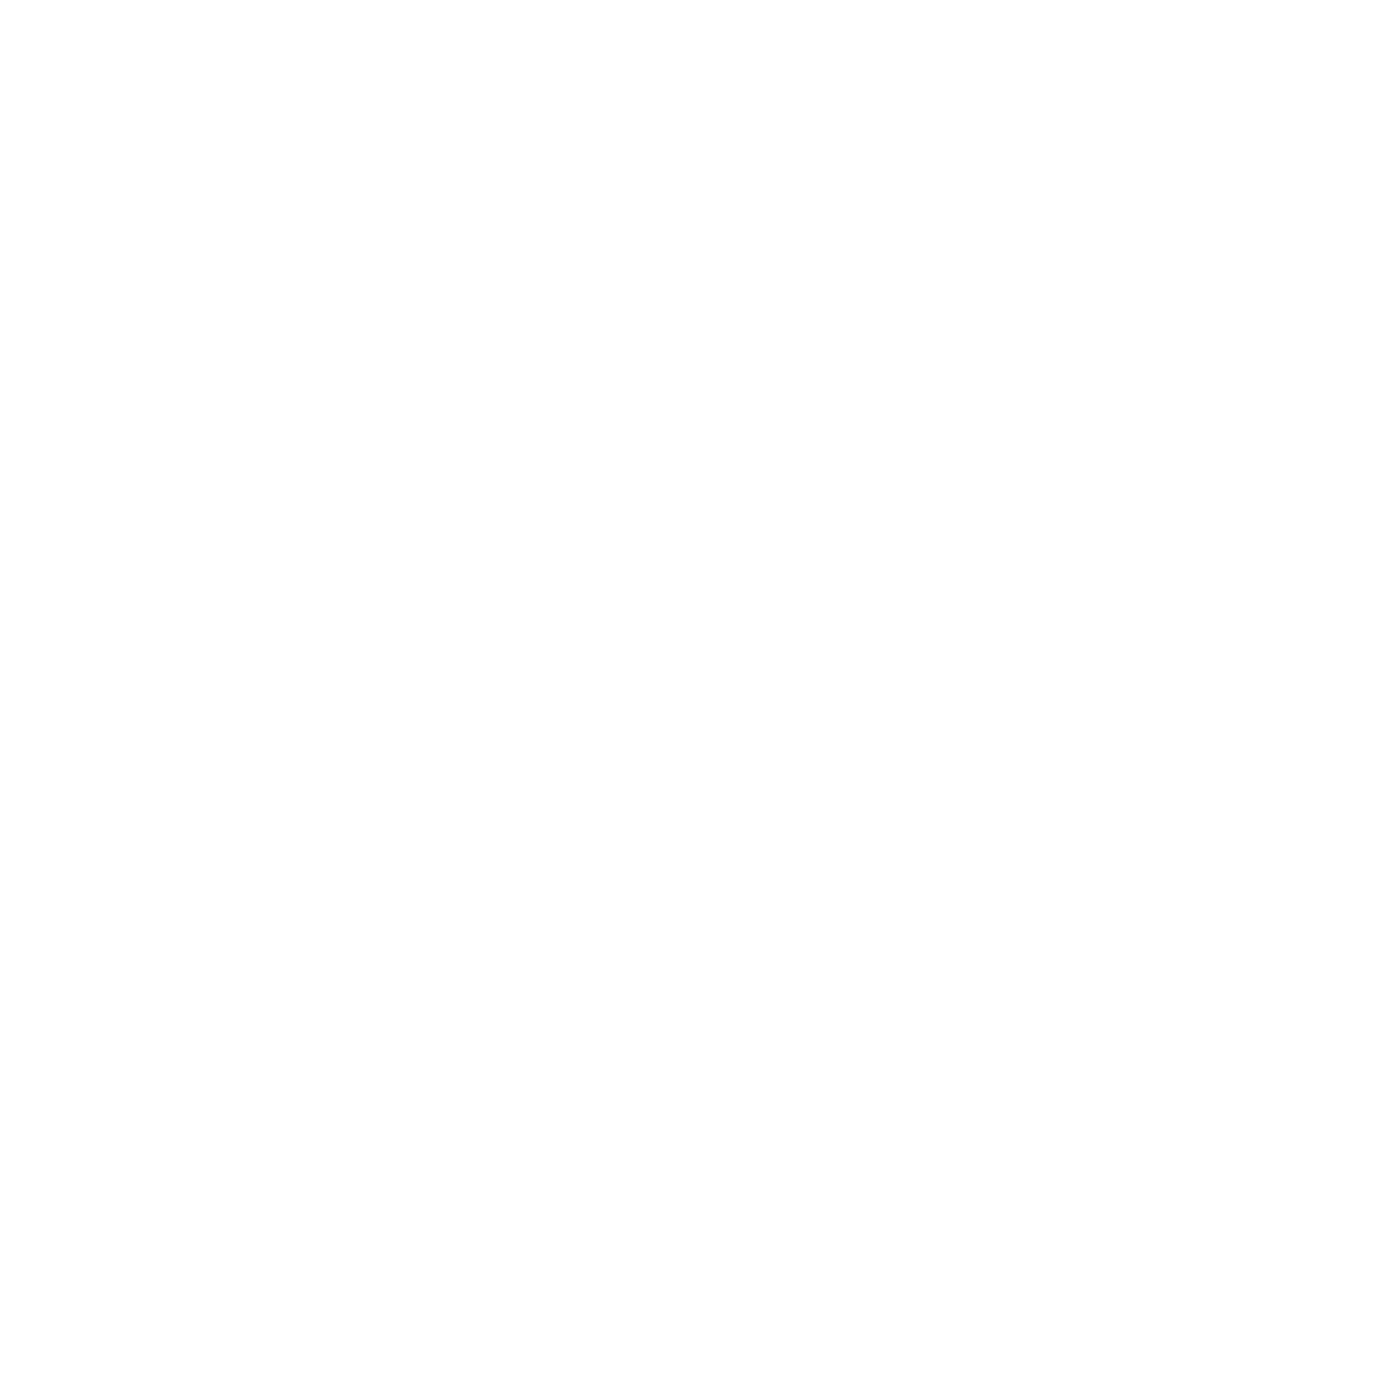

In [55]:
fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2,2,figsize=(14,14))

ax1.set_title('The realization es_perm',fontsize=25)
im1 = ax1.imshow(es_perm,cmap='jet',origin='lower', aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none' )
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

ax2.set_title('The realization M',fontsize=25)
im2 = ax2.imshow(realM ,cmap='jet',origin='lower', aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none' )
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

ax3.set_title('The mean of EnKF',fontsize=25)
im3 = ax3.imshow(mean_perm ,cmap='jet',origin='lower' , aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

ax4.set_title('The Truth',fontsize=25)
im4 = ax4.imshow(truth_perm ,cmap='jet',origin='lower' , aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none')
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbar4 = plt.colorbar(im4, cax=cax4)

# 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 
#'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'

In [56]:
perm._means = DotDict((k, perm[k].mean(axis=0)) for k in perm
                      if not k.startswith("_"))

<IPython.core.display.Javascript object>


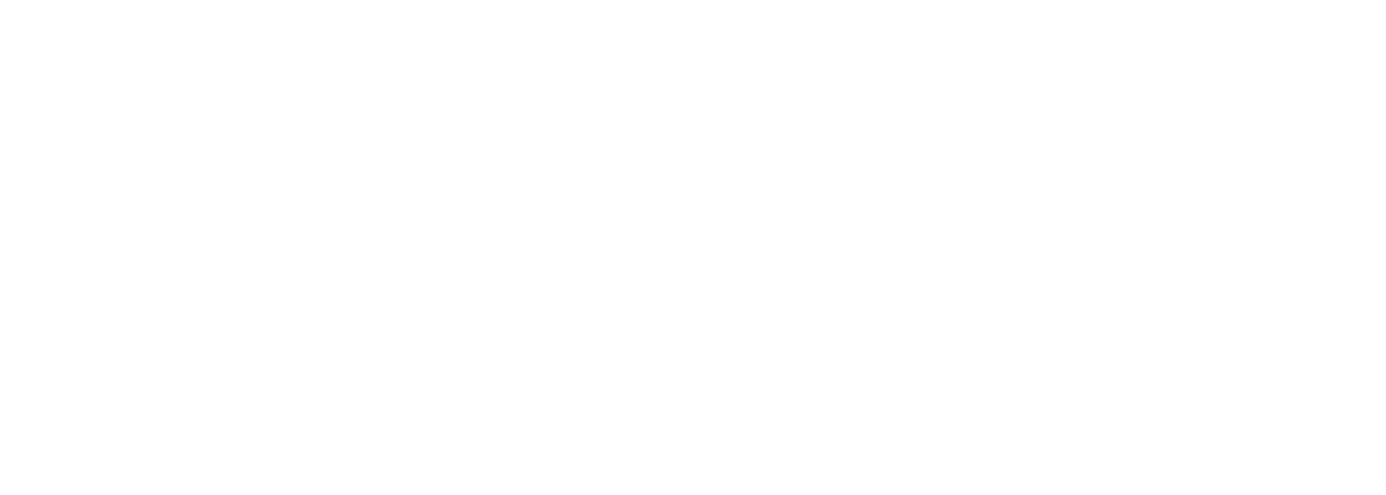

In [57]:
plots.fields(model, 170, plots.field, perm._means,
             figsize=(14, 5), cmap=cmap,
             title="Truth and mean fields.");

## Past production (data mismatch)

We already have the past true and prior production profiles. Let's add to that the production profiles of the posterior.

In [58]:
wsat.past.EnKF, prod.past.EnKF = forecast(nTime, wsat.initial.Prior, perm.EnKF)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

In [59]:
wsat.past.ES, prod.past.ES = forecast(nTime, wsat.initial.Prior, perm.ES)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

In [60]:
wsat.past.iES, prod.past.iES = forecast(nTime, wsat.initial.Prior, perm.iES)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

We can also apply the ES update (its X5 matrix, for those familiar with that terminology) directly to the production data of the prior, which doesn't require running the model again (like we did immediately above). Let us try that as well.

In [61]:
def ravelled(fun, xx):
    shape = xx.shape
    xx = xx.reshape((shape[0], -1))
    yy = fun(xx)
    return yy.reshape(shape)

In [62]:
prod.past.ES0 = ravelled(ES, prod.past.Prior)

Plot them all together:

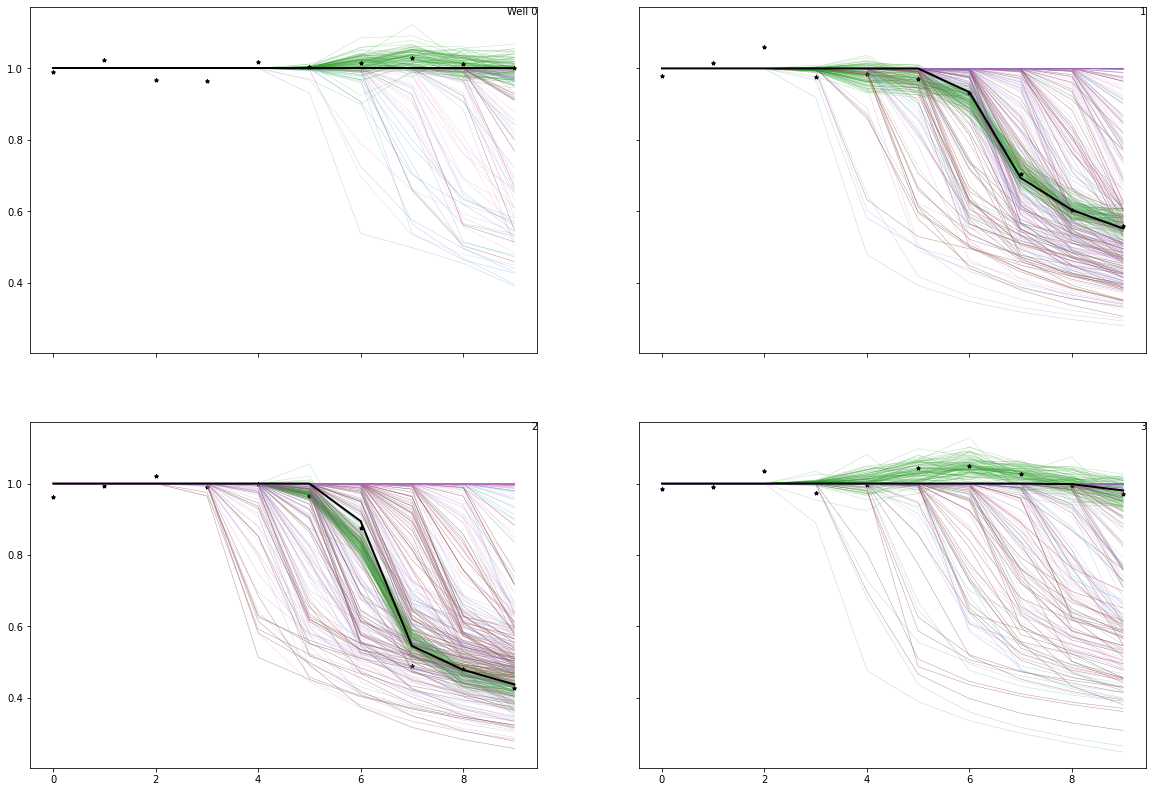

In [63]:
# The notebook/NbAgg backend fails after a few toggles
%matplotlib inline

v = plots.productions(prod.past, 175, figsize=(20, 14))

#### Data mismatch

In [64]:
print("Stats vs. past production (i.e. NOISY observations)")
RMS_all(prod.past, vs="Truth")   #Noisy or Truth, Prior

Stats vs. past production (i.e. NOISY observations)
Noisy   : 0.1456 (rmse),  0.1472 (std)
Prior   : 0.1471 (rmse),  0.1072 (std)
EnKF    : 0.0694 (rmse),  0.1233 (std)
ES      : 0.1392 (rmse),  0.0935 (std)
iES     : 0.0452 (rmse),  0.1020 (std)
ES0     : 0.0177 (rmse),  0.0177 (std)


Note that the data mismatch is significantly reduced. This may be the case even if the updated permeability field did not have a reduced rmse (overall, relative to that of the prior prior). The "direct" forecast (essentially just linear regression) may achieve even lower rmse, but generally, less realistic production plots.

##### Comment on prior
Note that the prior "surrounds" the data. This the likely situation in our synthetic case, where the truth was generated by the same random draw process as the ensemble.

In practice, this is often not the case. If so, you might want to go back to your geologists and tell them that something is amiss. You should then produce a revised prior with better properties.

Note: the above instructions sound like statistical heresy. We are using the data twice over (on the prior, and later to update/condition the prior). However, this is justified to the extent that prior information is difficult to quantify and encode. Too much prior adaptation, however, and you risk overfitting! Ineed, it is a delicate matter.

##### Comment on posterior
If the assumptions (statistical indistinguishability, Gaussianity) are not too far off, then the ensemble posteriors (ES, EnKS, ES0) should also surround the data, but with a tighter fit.

## Prediction
We now prediction the future production (and saturation fields) by forecasting using the (updated) estimates.

In [65]:
wsat.future.Truth, prod.future.Truth = simulate(
    model.step, nTime, wsat.past.Truth[-1], dt, obs)

Simulation:   0%|          | 0/10 [00:00<?, ?it/s]

In [66]:
wsat.future.Prior, prod.future.Prior = forecast(
    nTime, wsat.past.Prior[:, -1, :], perm.Prior)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

In [67]:
wsat.future.EnKF, prod.future.EnKF = forecast(
    nTime, wsat.updated.T, perm.EnKF)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

#### Which realization to plot?

In [68]:
real_num=2

In [69]:
from matplotlib import rc
rc('animation', html="jshtml")
ani = plots.dashboard(model, wsat.future.EnKF[real_num,:,:], prod.future.EnKF[real_num,:,:], animate=True, title="Truth");
ani

In [70]:
wsat.future.ES, prod.future.ES = forecast(
    nTime, wsat.past.ES[:, -1, :], perm.ES)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
wsat.future.iES, prod.future.iES = forecast(
    nTime, wsat.past.iES[:, -1, :], perm.iES)

Members:   0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
prod.future.ES0 = ravelled(ES, prod.future.Prior)

#### Plot future production

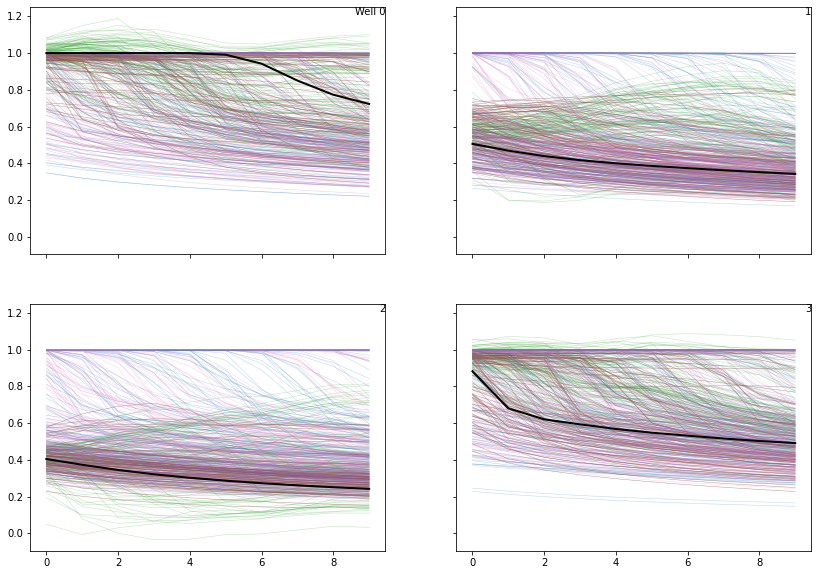

In [73]:
plots.productions(prod.future, 200, figsize=(14, 10), title="-- Future");
plt.pause(.3)

In [74]:
print("Stats vs. (supposedly unknown) future production")
RMS_all(prod.future, vs="Truth")

Stats vs. (supposedly unknown) future production
Prior   : 0.2779 (rmse),  0.2467 (std)
EnKF    : 0.0798 (rmse),  0.1539 (std)
ES      : 0.2284 (rmse),  0.2325 (std)
iES     : 0.1095 (rmse),  0.1827 (std)
ES0     : 0.1465 (rmse),  0.1500 (std)


## Plot of AHM + Forecast production

In [75]:
ttt = np.concatenate((prod.past.EnKF, prod.future.EnKF), axis=1)


In [76]:
# plots.productions(hash(ttt), 200, figsize=(14, 10), title="-- Future");
# plt.pause(.3)

## EnOpt

This section is still in construction. There are many details missing.

Cost function definition: total oil from production wells. This cost function takes for an ensemble of (wsat, perm) and controls (Q_prod) and outputs the corresponding ensemble of total oil productions.

Define step modulator by adding momentum to vanilla gradient descent.

<mark><font size="-1">
<em>Note:</em> Following cells edited by Siavash H.
</font></mark>

In [77]:
def total_oil(E, Eu):
    wsat, perm = E
    wsat, prod = forecast(int(nTime/nIntval), wsat, perm, Q_prod=Eu) #nTime =1 and loop over water sat also save each control in interval
    U_wsat = wsat
    return  U_wsat,np.sum(prod, axis=(1, 2))

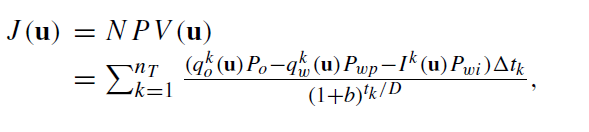

In [78]:
def obs_cost(water_sat):
    return [water_sat[:,:,i] for i in obs_inds]

tk : the accumulative time since the start of production

D : time span of 'b'

In [79]:
def obs_cost(water_sat):
    return [water_sat[:,:,i] for i in obs_inds]
def Cost_function(E, Eu, OPp=150, WPp=25, WPi=5, b=0.08 ,D=2):
    wsat, perm = E
    wsat, prod = forecast(int(nTime/nIntval), wsat, perm, Q_prod=Eu)
    U_wsat = wsat
    inj_wat = prod
    s1=obs_cost(wsat)
    s2=np.swapaxes(np.swapaxes(s1, 0,2) ,0,1)[:,1:,:]
    wat_out = np.multiply(s2,prod)
    oil_out = np.multiply((np.ones(s2.shape)-s2), prod)
    NPV_u=(oil_out * OPp - inj_wat * WPi - wat_out * WPp)
    NPV= np.sum(NPV_u, axis=(1,2))
    return U_wsat, NPV

In [80]:

# def EnOpt(wsats0, perms, u, nIntval, stepSize=1 ,out_Iter=10, inner_Iter=4):
#     np.random.seed(5)
#     C12 = 0.001 * np.eye(nProd)
#     mean_plot=[]
#     mx_fdr=[]
#     ens_plot=[]
#     cont_vec=[]
#     step_plot=[]
#     NOJ=[]                #non optimized J
#     mx_fdr=[]
#     OPJ=[]                #optimized J
#     cont_opt=[]
#     controls = np.zeros(u0.shape)
#     for _ in range(nIntval):
#         cV=u0[_,:]/sum(u0[_,:])
#         controls[_,:]=cV
    

#     for t in progbar(range(nIntval), desc="EnOpt "):
#         u=controls[t,:]
#         print('t',t)
#         N = len(wsats0)
#         E = wsats0, perms
#         mx_fdr=[]

#         print("Initial controls:", u)
#         J_init=Cost_function(E, np.tile(u, (N, 1)))[0].mean()
#         NOJ.append(J_init)
# #         print("Total oil initial",J_init)
#         Ju_hat_old_init =0.9*J_init                                              #just to initiation
#         cont_vec.append(u)
#         for o_itr in range(out_Iter+1):
#             Ju_hat_old=Ju_hat_old_init
#             u_new = u
#             Eu = u_new + randn(N, len(u_new)) @ C12.T                  #perturbation
#             Eu = Eu.clip(1e-5)
#             u_hat = np.tile(u_new, (N, 1))                             #u_hat is N*1 repeat of u guess
#             U_bar = (Eu - u_hat).T                                     #mean shifted
#             Ju = Cost_function(E, Eu)[0] 
#             Ju_hat = Cost_function(E, u_hat)[0]
#             Ju_h_fo=Ju_hat                          
#             j = (Ju - Ju_hat).T
#             G = (j @ U_bar.T)/N           #cross covariance or sensivity
#             G_inf = np.max(np.abs(G))     #or use np.linalg.norm(G, ord=np.inf) 
#             in_itr=1 ;stepSize=0.5

#             while (Ju_hat.mean()<Ju_hat_old.mean()) and (in_itr <=(inner_Iter)):

#                 print('inner iteration',in_itr)    

#                 u_new = u + (stepSize * G/G_inf)              #G/G_inf  is vector of steepest decsend
#                 u_new = np.abs(u_new)/np.sum(np.abs(u_new))
#                 u_new = u_new.clip(1e-5)
#                 u_hat_new = np.tile(u_new, (N, 1))
#                 Ju_hat = Cost_function(E, u_hat_new)[0]
#                 print('step size',stepSize)
#                 stepSize = stepSize/2                     #update step size for next iter if condiction is not satisfied
#                 in_itr +=1 
#                 u_w=deepcopy(u_new)

#                 if (Ju_hat.mean()>Ju_hat_old.mean()) or (in_itr not in range(inner_Iter)):  #check the condition
#                     u = deepcopy(u_w)
#                     step_plot.append(stepSize)

#                     break

#             else:
              
#                 u_new = u + (stepSize * G/G_inf)
#                 u_new = np.abs(u_new)/np.sum(np.abs(u_new))
#                 u_new  = u_new.clip(1e-5)
#                 u=deepcopy(u_new)

#             mx_fdr.append(Ju.mean())
#             cont_vec.append(u)
# #             print('controls end of each out iter: ',np.round(u, 2))
#             print('iteration:', o_itr)    
#             Ju_hat_old_init=Ju_h_fo
#             opt_idx = mx_fdr.index(np.max(mx_fdr))
        
#         u_opt = cont_vec[opt_idx]
#         J_opt,wsat0  = Cost_function(E, np.tile(u_opt, (N, 1)))
#         ens_plot.append(J_opt)
#         OPJ.append(J_opt.mean())
#         cont_opt.append(u_opt)
        
#     #     J=total_oil(E, np.tile(u, (N, 1)))[0].mean()
   
#     ens_plot = np.cumsum(ens_plot,axis=0)
#     ens_plot = np.insert(ens_plot, 0, 0, axis=0)
#     NPV_init = np.cumsum(NOJ)
#     NPV_init = np.insert(NPV_init, 0, 0)
#     NPV_opt = np.cumsum(OPJ)
#     NPV_opt = np.insert(NPV_opt, 0, 0)
#     cont_opt = np.asarray(cont_opt)
#     cont_plot = np.vstack((controls,cont_opt))
#     np.savetxt("cont_opt.csv", cont_opt, delimiter=",")
#     print("Total oil, averaged, initial: %.3f" % NPV_init[-1])
#     print("Total oil, averaged, final: %.3f" % NPV_opt[-1])
#     print('Improvement', round(100*(NPV_opt[-1]-NPV_init[-1])/abs(NPV_init[-1]),2),'%')
    
    
#     fig, (ax1, ax2) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [1, 0.33]},figsize=(15,10))
#     ax1.plot(np.arange(0,nTime+1,int(nTime/nIntval)),ens_plot,('#b0b0b0'),linewidth=0.25)
#     ax1.plot(np.arange(0,nTime+1,int(nTime/nIntval)),NPV_init,'-or',linewidth=2,label='Base NPV')
#     for a,b in zip(np.arange(0,nTime+1,int(nTime/nIntval)), NPV_init): ax1.text(a, b, str(round(b,2)),va='top',ha='left',rotation=-90,size='large')
#     ax1.plot(np.arange(0,nTime+1,int(nTime/nIntval)),NPV_opt,'-og',linewidth=2,label='Optimized NPV')    
#     for c,d in zip(np.arange(0,nTime+1,int(nTime/nIntval)), NPV_opt): ax1.text(c, d, str(round(d,2)),va='bottom',ha='right',rotation=90,size='large' )
#     ax1.legend()
#     ax1.set_title('NPV')
#     ax1.grid()
#     ax1.set_xticks(np.arange(0,nTime+1,int(nTime/nIntval)))    
#     ax2.plot(step_plot)
#     ax2.set_title('step size')
#     ax2.grid()
#     return u

In [81]:

# C12 = 0.001 * np.eye(nProd);
# u0  = np.random.rand(3,nProd)
# # uoo=u0+randn(N, len(u0)) @ C12.T
# # u0.shape

### Robust optimization 

In [185]:
 def EnOpt(wsats0, perms, u, nIntval, stepSize=1 ,out_Iter=10, inner_Iter=4):
    np.random.seed(5) 
    N = len(wsats0)
    wsat=wsats0
    E = wsat, perms
    C = 0.003 * np.eye(nProd*nIntval)
    mean_plot=[];Eu_m=np.empty((N*nProd*nIntval,1))
    cont_vec=[];step_plot=[]
    mx_fdr=[]   
    IOP=[] ;                                     
    cont_opt=[]
    RF_lst_i=[];obj_i=[];obj_J=[]
    
    controls = np.zeros(u0.shape)
    SZ_p=stepSize*np.ones(out_Iter)
    for _ in range(nIntval):
        cV=u0[_,:]/sum(u0[_,:])
        controls[_,:]=cV
    controls=np.reshape(controls,(-1,1));controls0=controls
    cont_vec.append(controls0)
    EG=E;u=np.reshape(controls, (nIntval,nProd))
    for e in range(nIntval):
        RF_init=Cost_function(EG, np.tile(u[e,:],(N, 1)))
        wsat=RF_init[0];
        EG = wsat[:,-1,:], perms        #index -1 : the last water saturation update, in prod, it's cumulative
        RF_lst_i.append(RF_init[1])
    obj_i=np.sum(np.mean(RF_lst_i,axis=1))
    Ju_hat_old_init =0.9*obj_i                                              #just to initiation
       
    stepSizeW=stepSize
    for o_itr in progbar(range(out_Iter), desc="EnOpt "):
            
        Ju_hat_old=Ju_hat_old_init
        u_new = controls
        Eu = np.tile(u_new,(1,N))+ C.T @ randn(nProd*nIntval, N)                   #perturbation
        Eu = Eu.clip(1e-5)
        Eu_m = np.append(Eu_m,np.reshape(Eu,(-1,1)),axis=1)
        u_hat = np.tile(u_new, (1,N))                            #u_hat is N*1 repeat of u guess
        U_bar = (Eu - u_hat)                                     #mean shifted
        print()
        EG=E;obj_J=[]    
        for e in range(nIntval):
            idx1=e*nProd;idx2=(e+1)*nProd
            Eu_e = Eu[idx1:idx2,:].T
            RF=Cost_function(EG, Eu_e)
            wsat=RF[0];
            EG = wsat[:,-1,:], perms
            obj_J.append(RF[1])      #ens of obj
        obj_f=np.sum(obj_J, axis=0)  #sum of n Intervals
        IOP.append(np.sum(obj_J,axis=0))
        EG=E;obj_Jh=[]
        for e in range(nIntval):
            idx1=e*nProd;idx2=(e+1)*nProd
            uh_e = u_hat[idx1:idx2,:].T
            RF_hat=Cost_function(EG, uh_e)
            wsat=RF_hat[0];
            EG = wsat[:,-1,:], perms
            obj_Jh.append(RF_hat[1])
        obj_f_jh=np.sum(obj_Jh, axis=0)        
        Ju_h_fo=obj_f_jh   #save for next loop   
        j = (obj_f - obj_f_jh).T
        G = (j @ U_bar.T)/N           #cross covariance or sensivity
        G_inf = np.max(np.abs(G))     #or use np.linalg.norm(G, ord=np.inf) 
        in_itr=1 
        stepSizeW=stepSize
        while (np.mean(obj_f_jh)<np.mean(Ju_hat_old)) and (in_itr <=inner_Iter): #change 

            print('inner iteration',in_itr)    
            u = np.reshape(controls,(-1,1))
            u_new = u + np.reshape((stepSizeW * G/G_inf),(-1,1))              #G/G_inf  is vector of steepest decsend
            u_new = np.abs(u_new)/np.sum(np.abs(u_new))
            u_new = u_new.clip(1e-5)
            u_hat_new = np.tile(u_new, (1,N))

            
            EG=E; obj_Jh=[]
            for e in range(nIntval):
                idx1=e*nProd;idx2=(e+1)*nProd                  #this part make u readable for forward model
                uh_e = u_hat_new[idx1:idx2,:].T             
                RF_hat=Cost_function(EG, uh_e)
                wsat=RF_hat[0]
                EG = wsat[:,-1,:], perms
                obj_Jh.append(RF_hat[1])
            obj_f_jh=np.sum(obj_Jh, axis=0)
            stepSizeW = stepSizeW/2                     #update step size for next iter if condiction is no satisfied
            in_itr +=1 
            u_w=deepcopy(u_new)
            
            if (np.mean(obj_f_jh)>np.mean(Ju_hat_old)) or (in_itr not in range(inner_Iter)):  #check the condition
                controls = deepcopy(u_w)
                step_plot.append(stepSize)
                SZ_p[o_itr]=stepSize/2
                break

        else:
            u = np.reshape(controls,(-1,1))  
            u_new = u + np.reshape((stepSize * G/G_inf),(-1,1))
            u_new = np.reshape(u_new, (-1,4))
            u_new = (np.abs(u_new.T)/np.sum(np.abs(u_new),axis=1)).T
            u_new  = u_new.clip(1e-5)
            controls=deepcopy(np.reshape(u_new,(-1,1)))
        mx_fdr.append(obj_f.mean())  
        mean_plot.append(obj_f.mean())
        cont_vec.append(controls)
        print('iteration:', o_itr+1)    
        Ju_hat_old_init=Ju_h_fo
    opt_idx = mean_plot.index(max(mx_fdr))
    u_opt = cont_vec[opt_idx]
    u_ens_opt=np.reshape(Eu_m[:,opt_idx],(-1,N))
    RF_lst_e=[]
    EG=E;u_f=np.reshape(u_opt, (nIntval,nProd))  
    for e in range(nIntval):
            idx1=e*nProd;idx2=(e+1)*nProd
            Eu_e = u_ens_opt[idx1:idx2,:].T
            RF_o=Cost_function(EG, Eu_e)
            wsat=RF_o[0];
            EG = wsat[:,-1,:], perms
            RF_lst_e.append(RF_o[1])      #ens of obj
    RF_lst_o=np.sum(np.mean(RF_lst_e,axis=1))  #sum of n Intervals  
    print("Initial controls:\n",np.reshape(np.round(controls0, 2),(-1,nProd)))
    print("Final controls:\n" ,np.reshape(np.round(u_opt, 2),(-1,nProd)))
    ens_plot = np.asarray(RF_lst_e)
    ens_plot = np.cumsum(np.insert(ens_plot, 0, 0, axis=0),axis=0)
    NPV_init = np.mean(RF_lst_i,axis=1)
    NPV_init = np.cumsum(np.insert(NPV_init, 0, 0))
    NPV_opt = np.mean(RF_lst_e,axis=1)
    NPV_opt = np.cumsum(np.insert(NPV_opt, 0, 0))
    cont_opt = np.asarray(cont_vec)
    np.savetxt("cont_opt.csv", u_opt, delimiter=",")
    print("Total oil, averaged, initial: %.3f" % NPV_init[-1])
    print("Total oil, averaged, final: %.3f" % NPV_opt[-1])
    print('Improvement', round(100*(NPV_opt[-1]-NPV_init[-1])/abs(NPV_init[-1]),2),'%')

    
    fig, (ax1, ax2,ax3) = plt.subplots(3, 1,gridspec_kw={'height_ratios': [1,0.6, 0.4]},figsize=(15,10))
    ax1.plot(np.arange(0,nTime+1,int(nTime/nIntval)),ens_plot,('#b0b0b0'),linewidth=0.25)
    ax1.plot(np.arange(0,nTime+1,int(nTime/nIntval)),NPV_init,'-or',linewidth=2,label='Base NPV')
    for a,b in zip(np.arange(0,nTime+1,int(nTime/nIntval)), NPV_init): ax1.text(a, b, str(round(b,2)),va='top',ha='left',rotation=-90,size='large')
    ax1.plot(np.arange(0,nTime+1,int(nTime/nIntval)),NPV_opt,'-og',linewidth=2,label='Optimized NPV')    
    for c,d in zip(np.arange(0,nTime+1,int(nTime/nIntval)), NPV_opt): ax1.text(c, d, str(round(d,2)),va='bottom',ha='right',rotation=90,size='large' )
    ax1.set_xticks(np.arange(0,nTime+1,int(nTime/nIntval))) 
    ax1.legend()
    ax1.set_title('NPV')
    ax1.grid()
    ax2.plot(np.arange(out_Iter)+1,IOP,('#b0b0b0'),linewidth=0.25)
    ax2.plot(np.arange(out_Iter)+1,np.mean(IOP,axis=1),'-or',linewidth=2)
    ax2.set_title("Objective Function")
    for e,f in zip(np.arange(out_Iter)+1, np.mean(IOP,axis=1)): ax2.text(e, f, str(round(f,2)),rotation=90,size='large')
    ax2.set_xticks(np.arange(out_Iter)+1)    
    ax3.scatter(np.arange(out_Iter)+1,SZ_p,'-o')
    for e,f in zip(np.arange(out_Iter)+1, SZ_p): ax3.text(e, f, str(round(f,2)),rotation=90,size='large')
    ax3.set_title('step size')
    ax3.grid()
    return u 

#### Vector of  (initial guess / random) controls 
Controls should have shape of n-well * t-time interval


Run EnOpt to optimize future prodoction

In [155]:
nIntval=3
u0  = np.random.rand(nIntval,nProd)

# u0 = np.array ([0.34,0.,0.45,0.21,0.26, 0.32 ,0.11, 0.31,0.35, 0.12, 0.14, 0.39])
#                          #Import vector of inital control in row shape.
# u0 = np.reshape(u0,(nIntval,nProd))
u0

array([[0.08414878, 0.88177357, 0.80812914, 0.64569247],
       [0.3229058 , 0.02122271, 0.34289618, 0.49255079],
       [0.15075835, 0.70857649, 0.57773069, 0.43767763]])

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Base NPV [170.53016896 139.526102   141.05592205]


EnOpt :   0%|          | 0/10 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (1, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [170.53016896 139.526102   141.05592205]
iteration: 1



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (2, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [194.01709852 170.2805774  170.7707202 ]
iteration: 2



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (3, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [185.03756519 165.93998837 175.1080196 ]
inner iteration 1


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jhw (3, 100) [187.26118074 174.45598667 190.20099068]
stepSize 0.5
iteration: 3



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (4, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [187.26118074 174.45598667 190.20099068]
iteration: 4



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (5, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [184.95060814 163.06784867 171.18384163]
inner iteration 1


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jhw (3, 100) [194.12762219 179.94263149 189.28505332]
stepSize 0.5
iteration: 5



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (6, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [194.12762219 179.94263149 189.28505332]
iteration: 6



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (7, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [194.96926361 174.94952439 178.37303768]
inner iteration 1


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jhw (3, 100) [193.55355155 177.12563384 183.97291485]
inner iteration 2


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jhw (3, 100) [199.88275328 190.53772752 191.56691062]
stepSize 0.5
iteration: 7



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (8, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [199.88275328 190.53772752 191.56691062]
iteration: 8



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (9, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [184.44061085 159.07829715 164.27512943]
inner iteration 1


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jhw (3, 100) [192.2291815  168.76666893 177.06377297]
inner iteration 2


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jhw (3, 100) [202.25012416 179.6434248  183.6472335 ]
inner iteration 3


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jhw (3, 100) [193.48931596 168.52308981 173.76983895]
stepSize 0.5
iteration: 9



Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

sha obj (10, 100)


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

jh (3, 100) [193.48931596 168.52308981 173.76983895]
iteration: 10


Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Members:   0%|          | 0/100 [00:00<?, ?it/s]

Initial controls:
 [[0.03 0.36 0.33 0.27]
 [0.27 0.02 0.29 0.42]
 [0.08 0.38 0.31 0.23]]
Final controls:
 [[0.28 0.03 0.01 0.02]
 [0.15 0.07 0.07 0.01]
 [0.09 0.04 0.11 0.11]]
sha obj (10, 100)
Total oil, averaged, initial: 451.112
Total oil, averaged, final: 548.152
Improvement 21.51 %
stp [0.5  0.5  0.25 0.5  0.25 0.5  0.25 0.5  0.25 0.5 ]


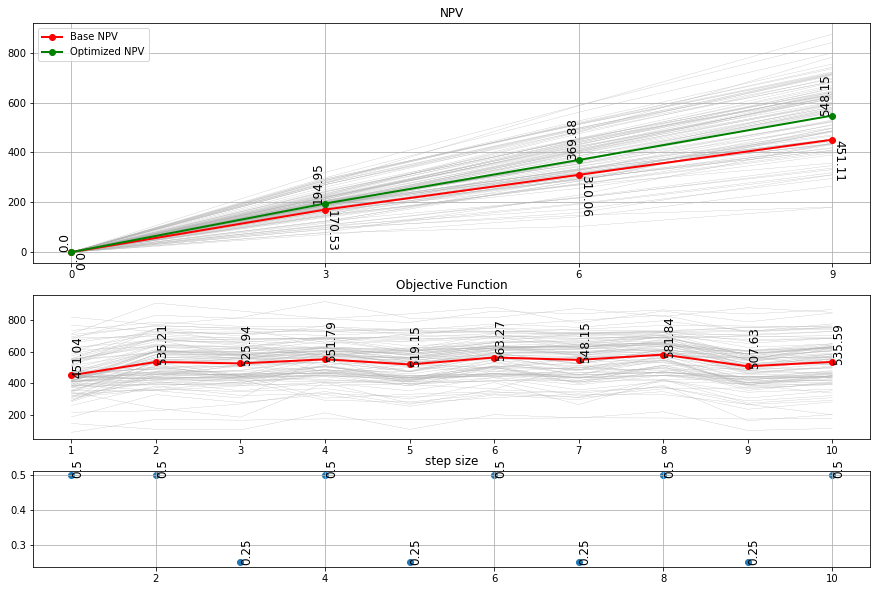

In [183]:
u   = EnOpt(
            wsat.past.EnKF[:, -1, :], #move index to def??      # water saturation
            perm.EnKF,                                        # Perm
            u0,                                               # well rates
            nIntval=3,                                        
            stepSize=0.5,
            out_Iter=10,
            inner_Iter=4,
           )

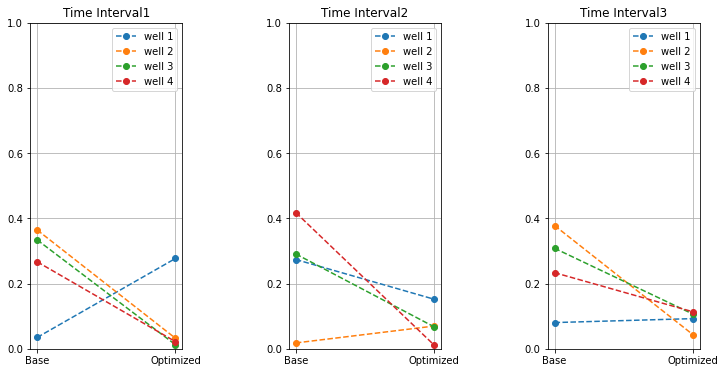

In [184]:

cont_opt = np.asmatrix(np.genfromtxt('cont_opt.csv', delimiter=","))
u = np.zeros(u0.shape)
for _ in range(nIntval):
    cV=u0[_,:]/sum(u0[_,:])
    u[_,:]=cV
u1=np.reshape(u, (1,-1))      
fig, axs = plt.subplots(1,nIntval, figsize=(12, 6), facecolor='w', edgecolor='r')
fig.subplots_adjust( wspace=.7)
axs = axs.ravel();labels = ['Base','Optimized'];x=np.arange(2)
for i in range(nIntval):
    idx1=i*nProd;idx2=(i+1)*nProd
    a=u1[:,idx1:idx2,];b=cont_opt[:,idx1:idx2]
    c=np.row_stack((a,b))
    axs[i].set_title('Time Interval{}'.format(i+1))
    axs[i].plot(x,c,'--o')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(labels)
    axs[i].set_ylim(0, 1)
    axs[i].legend(['well 1','well 2','well 3','well 4'])
    axs[i].grid()
plt.show()

In [87]:
stop

NameError: name 'stop' is not defined

In [ ]:
# well_grid = np.linspace(0.1, .9, 2)
# well_grid = np.meshgrid(well_grid, well_grid)
# well_grid = np.stack(well_grid)
# well_grid = well_grid.T.reshape((-1, 2))
# well_grid = np.c_[ well_grid, u ]
# model.init_Q(
#     inj =[[0.50, 0.50, 1]],
#     prod=well_grid,
# ); 
# well_grid


# # u   = EnOpt(wsat.initial.Prior,       #water saturation 
# #             perm.Prior,               #Perm
# #             u0,                       
# #             stepSize=1,out_Iter=10)

## Closed Loop Reservoir Managmanet

In first step, optimze the prior with engineering inital guess of controls. 

In [ ]:
# nIntval=3  
# u0  = np.random.rand(nIntval,nProd)   #just random here
# u   = EnOpt(
#             wsat.initial.Prior, #move index to def      # water saturation
#             perm.Prior,                                        # Perm
#             u0,                                               # well rates
#             nIntval=3,                                        
#             stepSize=0.5,
#             out_Iter=10,
#             inner_Iter=4,
#            )

In next step of CLRM the final optimzed controls form 1st step will be inserted to RG/P model and simulate the truth to genrate production data.

In [ ]:
u_opt_1 = np.array([0.71, 0.05, 0.04, 0.21]) #optimized control form first interval.

In [ ]:
well_grid = np.linspace(0.1, .9, 2)
well_grid = np.meshgrid(well_grid, well_grid)
well_grid = np.stack(well_grid)
well_grid = well_grid.T.reshape((-1, 2))
well_grid = np.c_[ well_grid, u_opt_1 ]
model.init_Q(
    inj =[[0.50, 0.50, 1]],
    prod=well_grid,
); 
well_grid

Then simulate the truth with optimzed controls over 1st time inteval and production data will be used to generate niosy observation.

In [ ]:
nTime=3
wsat.past.Truth, prod.past.Truth = simulate(
    model.step, nTime, wsat.initial.Truth, dt, obs) 

In [ ]:
rc('animation', html="jshtml")
ani = plots.dashboard(model, wsat.past.Truth, prod.past.Truth, animate=True, title="Truth");
ani

In [ ]:
nobs=nTime                                              # num. of obs (per time)                                     
prod.past.Noisy = prod.past.Truth.copy()
nProd = len(model.producers)  
R = 1e-3 * np.eye(nProd)
for iT in range(nobs):
    prod.past.Noisy[iT] += sqrt(R) @ randn(nProd)

In [ ]:
fig, ax = freshfig(301)
hh_y = plots.production1(ax, prod.past.Truth, obs=prod.past.Noisy)
plt.pause(.1)

These Noisy data and observation will be used to update the prior realizations.

In [ ]:
perm.CLRM,  wsat.CLRM=EnKF(mf_k=perm.Prior.T,                       #dynamic_reservoir_model
                              Xf_k=wsat.initial.Prior.T,               #state_variables,
                              gf_k=(prod.past.Prior[:,0,:]).T,          #observation_current
                              nProd=nProd, 
                              Noisy=prod.past.Noisy,
                              size=model.M,
                              up_time=3)

In [ ]:
realM=(perm.CLRM[1,:].reshape(Nx,Ny)).T

mean_perm_r=np.mean(perm.CLRM,axis=0)
mean_perm=mean_perm_r.reshape(Nx,Ny).T

truth_perm_r=np.mean(perm.Truth,axis=0)
truth_perm=truth_perm_r.reshape(Nx,Ny).T


EnKF_perm_r=np.mean(perm.EnKF,axis=0)
En_perm=EnKF_perm_r.reshape(Nx,Ny).T
fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2,2,figsize=(14,14))

ax1.set_title('The mean of EnKF',fontsize=25)
im1 = ax1.imshow(En_perm,cmap='jet',origin='lower', aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none' )
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

ax2.set_title('The realization M',fontsize=25)
im2 = ax2.imshow(realM ,cmap='jet',origin='lower', aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none' )
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

ax3.set_title('The mean of CLRM',fontsize=25)
im3 = ax3.imshow(mean_perm ,cmap='jet',origin='lower' , aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

ax4.set_title('The Truth',fontsize=25)
im4 = ax4.imshow(truth_perm ,cmap='jet',origin='lower' , aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none')
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbar4 = plt.colorbar(im4, cax=cax4)

# 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 
#'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'

Using updated permeability prior and optimized controls from first time interval, CLRM for 2nd time interval should be : 

In [ ]:

u0  = np.array([[0.71, 0.05, 0.04, 0.21],[0.32 ,0.25, 0.08, 0.35],[0.2, 0.12 ,0.34 ,0.34]])   
u   = EnOpt(
            wsat.initial.Prior,                                # water saturation
            perm.CLRM,                                        # Perm
            u0,                                                # well rates
            nIntval=3,                                        
            stepSize=0.5,
            out_Iter=10,
            inner_Iter=4,
           )

Same as before, new set of controls in 2nd interval will be inserted to the GP/M, simulate production data and noise will be added.

In [ ]:
u_opt_2 = np.array([0.32,0.25, 0.08, 0.35]) #optimized control form second interval.

In [ ]:

well_grid = np.linspace(0.1, .9, 2)
well_grid = np.meshgrid(well_grid, well_grid)
well_grid = np.stack(well_grid)
well_grid = well_grid.T.reshape((-1, 2))
well_grid = np.c_[ well_grid, u_opt_2 ]
model.init_Q(
    inj =[[0.50, 0.50, 1]],
    prod=well_grid,
); 
well_grid

Please note that, since it is the second time interval, water saturation has been changed.

In [ ]:
nTime=3
wsat.past.Truth, prod.past.Truth = simulate(
    model.step, nTime, wsat.initial.Truth, dt, obs) 

In [ ]:
# model.step  #remove it  later

In [ ]:
wsat.past.Truth, prod.past.Truth = simulate(
    model.step, nTime, wsat.past.Truth[-1,:], dt, obs)   

In [ ]:
rc('animation', html="jshtml")
ani = plots.dashboard(model, wsat.past.Truth, prod.past.Truth, animate=True, title="Truth");
ani

In [ ]:
nobs=nTime                                              # num. of obs (per time)                                     
prod.past.Noisy = prod.past.Truth.copy()
nProd = len(model.producers)  
R = 1e-3 * np.eye(nProd)
for iT in range(nobs):
    prod.past.Noisy[iT] += sqrt(R) @ randn(nProd)

In [ ]:
fig, ax = freshfig(303)
hh_y = plots.production1(ax, prod.past.Truth, obs=prod.past.Noisy)
plt.pause(.1)

In [ ]:
perm.CLRM,  wsat.updated=EnKF(mf_k=perm.CLRM.T,                       #dynamic_reservoir_model
                              Xf_k=wsat.CLRM,                           #state_variables,
                              gf_k=(prod.past.Prior[:,0,:]).T,          #observation_current
                              nProd=nProd, 
                              Noisy=prod.past.Noisy,
                              size=model.M,
                              up_time=3)

In [ ]:
realM=(perm.CLRM[1,:].reshape(Nx,Ny)).T

mean_perm_r=np.mean(perm.CLRM,axis=0)
mean_perm=mean_perm_r.reshape(Nx,Ny).T

truth_perm_r=np.mean(perm.Truth,axis=0)
truth_perm=truth_perm_r.reshape(Nx,Ny).T


EnKF_perm_r=np.mean(perm.EnKF,axis=0)
En_perm=EnKF_perm_r.reshape(Nx,Ny).T
fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2,2,figsize=(14,14))

ax1.set_title('The realization EnKF',fontsize=25)
im1 = ax1.imshow(En_perm,cmap='jet',origin='lower', aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none' )
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

ax2.set_title('The realization M',fontsize=25)
im2 = ax2.imshow(realM ,cmap='jet',origin='lower', aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none' )
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

ax3.set_title('The mean of CLRM',fontsize=25)
im3 = ax3.imshow(mean_perm ,cmap='jet',origin='lower' , aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

ax4.set_title('The Truth',fontsize=25)
im4 = ax4.imshow(truth_perm ,cmap='jet',origin='lower' , aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none')
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbar4 = plt.colorbar(im4, cax=cax4)

# 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 
#'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'

Finally, with updated prior and optimized controls in 2 time intervals:

In [ ]:
 #    
u0  = np.array([[0.7,  0.05, 0.04, 0.21],[0.32,0.25, 0.08, 0.35],[0.2, 0.12, 0.34, 0.34]])   
u   = EnOpt(
            wsat.initial.Prior,                                # water saturation
            perm.CLRM,                                        # Perm
            u0,                                                # well rates
            nIntval=3,                                        
            stepSize=0.5,
            out_Iter=10,
            inner_Iter=4,
           )

In [ ]:
# to compare with first plot

In following part, noise will be added to production data as observations. Then these data will used in EnKF to updated the geology model.

In [ ]:
prod.past.Noisy = prod.past.Truth.copy()
nProd = len(model.producers)  
R = 1e-3 * np.eye(nProd)
for iT in range(nobs):
    prod.past.Noisy[iT] += sqrt(R) @ randn(nProd)

In [ ]:
%matplotlib inline

v = plots.productions(prod.past, 400, figsize=(20, 14)) #with new flow rate

In [ ]:
rc('animation', html="jshtml")
ani = plots.dashboard(model, wsat.past.Truth, prod.past.Truth, animate=True, title="Truth");
ani

In [ ]:
perm.CLRM,  wsat.CLRM= EnKF(mf_k=perm.Prior.T,                       #dynamic_reservoir_model
                               Xf_k=wsat.initial.Prior.T,               #state_variables,
                               gf_k=(prod.past.Prior[:,0,:]).T          #observation_current
                              )

# write about the steps 

In [ ]:
plots.fields(model, 100, plots.field, perm.CLRM,   #perm.EnKF[10:22]
             figsize=(14, 10), cmap=cmap,
             title="Enkf posterior -- some realizations of perm");

In [ ]:
print("Stats vs. true field")
RMS_all(perm, vs="Truth")

In [ ]:
perm_mat=perm.CLRM
# calling first 10 realaztion

realM=(perm_mat[1,:].reshape(Nx,Ny)).T
realN=(perm_mat[10,:].reshape(Nx,Ny)).T

mean_perm_r=np.mean(perm_mat,axis=0)
mean_perm=mean_perm_r.reshape(Nx,Ny).T

truth_perm_r=np.mean(perm.Truth,axis=0)
truth_perm=truth_perm_r.reshape(Nx,Ny).T


EnKF_perm_r=np.mean(perm.EnKF,axis=0)
En_perm=EnKF_perm_r.reshape(Nx,Ny).T

In [ ]:
fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2,2,figsize=(10,10))

ax1.set_title('The realization EnKF_perm',fontsize=25)
im1 = ax1.imshow(En_perm,cmap='jet',origin='lower', aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none' )
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

ax2.set_title('The realization M',fontsize=25)
im2 = ax2.imshow(realM ,cmap='jet',origin='lower', aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none' )
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

ax3.set_title('The mean of CLRM',fontsize=25)
im3 = ax3.imshow(mean_perm ,cmap='jet',origin='lower' , aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3)

ax4.set_title('The Truth',fontsize=25)
im4 = ax4.imshow(truth_perm ,cmap='jet',origin='lower' , aspect='auto',vmin=-2.5,vmax=2.5,interpolation='none')
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbar4 = plt.colorbar(im4, cax=cax4)

# 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 
#'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'

In [ ]:
u   = EnOpt(
            wsat.CLRM.T,  # can't move slicing to def/transpos issue      # Water saturation 
            perm.CLRM,                                        # Perm
            u0,                                               # Well rates vactor
            nIntval=3,                                        # Number of control time intervals (optimizer options)
            stepSize=0.5,                                     # Initial step size(optimizer options)
            out_Iter=10,                                      # Outer iteration (optimizer options)
            inner_Iter=4,                                      # Inner itearation (optimizer options)
           )

In [ ]:
well_grid = np.linspace(0.1, .9, 2)
well_grid = np.meshgrid(well_grid, well_grid)
well_grid = np.stack(well_grid)
well_grid = well_grid.T.reshape((-1, 2))
well_grid = np.c_[ well_grid, fin_opt_cont ]
model.init_Q(
    inj =[[0.50, 0.50, 1]],
    prod=well_grid,
); 
well_grid

In [ ]:
wsat.future.Truth, prod.future.Truth = simulate(
    model.step, nTime, wsat.past.Truth[-1], dt, obs)

In [ ]:
wsat.future.Prior, prod.future.Prior = forecast(
    nTime, wsat.past.Prior[:, -1, :], perm.Prior)

In [ ]:
wsat.future.CLRM, prod.future.CLRM = forecast(
    nTime, wsat.CLRM.T, perm.CLRM)